In [49]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette("Spectral")
sns.set_style('whitegrid')

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import TomekLinks

In [4]:
import keras
import tensorflow as tf
import tensorflow.keras.layers as KL

In [43]:
def plotloss(history_dict, loss='loss', val_loss='val_loss', fileName=""):
    '''
    See helpers documentation from 'Michael Telahun: Exploring Information for Quantum Assisted Learning'
    '''    
    loss_values = history_dict[loss]
    val_loss_values = history_dict[val_loss]
    epochs = range(1, len(loss_values) + 1)
    
    plt.figure(figsize=(12,8))
    plt.plot(epochs, loss_values, 'r', label='Training Loss')
    plt.plot(epochs, val_loss_values, 'g', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    
#     fh.SaveFigure(plt, fileName + "-Loss")
    
def plotacc(history, acc='acc', val_acc='val_acc', fileName=""):
    '''
    See helpers documentation from 'Michael Telahun: Exploring Information for Quantum Assisted Learning'
    '''
    acc = history[acc]
    val_acc = history[val_acc]
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12,8))
    plt.plot(epochs, acc, 'r', label='Training Acc')
    plt.plot(epochs, val_acc, 'g', label='Validation Acc')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

#     fh.SaveFigure(plt, fileName + "-Accuracy")

def plot_confusion_matrix(cm, classes, fileName="",
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.BrBG):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.figure(figsize=(12,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

#     fh.SaveFigure(plt, fileName + "-CNF_Matrix")
    
def Metriks_Multi(model, history, x_test, y_test, thresh=99, class_names=[0,1], loss='loss', val_loss='val_loss', acc='acc', val_acc='val_acc', fileName=""):
    '''
    See helpers documentation from 'Michael Telahun: Exploring Information for Quantum Assisted Learning'
    '''
    sns.set_style('dark')
    history_dict = history
    # history_dict.keys()

    evalulation = model.evaluate(x_test, y_test)
    
    for i, ele in enumerate(evalulation):
        print("Model Evaluation:", str(model.metrics_names[i]) + " ~ %.2f%%" % (ele * 100.0))
    ## force to binary behavior
    y_pred_ = []
    y_pred = model.predict(x_test)
    if thresh != 99:
        y_pred[y_pred < thresh] = class_names[0]
        y_pred[y_pred >= thresh] = class_names[1]
        y_pred_ = y_pred
    else:
        for i in range(0,len(y_pred)):
            y_pred_.append(np.argmax(y_pred[i]))
    print("-"*90)
    print(classification_report(y_test, y_pred))
    print("-"*90)
    
    accuracy = accuracy_score(y_test, y_pred_)
    # print("Accuracy: %.2f%%" % (accuracy * 100.0))
    
    cnf_matrix = confusion_matrix(y_test, y_pred_, labels=class_names)
    
    plotloss(history_dict, loss, val_loss, fileName=fileName)
    plotacc(history_dict, acc, val_acc, fileName=fileName)
    
    plt.rcdefaults()
    plot_confusion_matrix(cnf_matrix, classes=list(map(str, class_names)), title='Confusion matrix', fileName=fileName)
    

    return [model.metrics_names, evalulation, y_pred_, classification_report(y_test, y_pred, output_dict=True), cnf_matrix]


def SimpleMLP(train=[], val=[], dropout=0.15, neuronsPerLayer=[256, 128, 64, 64], EPOCHS=1, BATCH_SIZE=2):
    '''
    See helpers documentation from 'Michael Telahun: Exploring Information for Quantum Assisted Learning'
    '''    
    assert (len(train) == 2), "Need x and y for train: [x_train, y_train]"
    assert (len(val) == 2), "Need x and y for val: [x_val, y_val]"
    inshape = train[0].shape
    model = tf.keras.Sequential()
    model.add(KL.Dense(neuronsPerLayer[0], input_shape=(7,)))
    model.add(KL.Dropout(dropout))
    model.add(KL.Dense(neuronsPerLayer[1]))
    model.add(KL.Dropout(dropout))
    model.add(KL.Dense(neuronsPerLayer[2]))
    model.add(KL.Dropout(dropout))
    model.add(KL.Dense(neuronsPerLayer[3]))
    model.add(KL.Dense(1, activation='relu'))
    
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),#rmsprop
            loss='mse',
            metrics='accuracy')
    
    history = model.fit(train[0],
                    train[1],
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE)
#                     validation_data=(val[0], val[1]))
    return model, history

In [7]:
def plotDf(df, layOut=(4,4)):
    df.plot(kind='line', subplots=True, layout=layOut, figsize=(22,50))
    plt.show()
    
def normalize(a):
    return (a-a.min())/(a.max()-a.min())

In [8]:
df = pd.read_csv("training.csv")

In [9]:
df['Idle Mean'].value_counts()[0]/len(df)

0.8631098054119594

In [10]:
df.Label.value_counts()

Benign    631275
ddos      129152
Name: Label, dtype: int64

In [11]:
dfddos = df[df["Label"]=="ddos"]
dfbenign = df[df["Label"]=="Benign"]

In [12]:
dfddos.Label.value_counts(), dfbenign.Label.value_counts()

(ddos    129152
 Name: Label, dtype: int64,
 Benign    631275
 Name: Label, dtype: int64)

In [13]:
dfddos = dfddos.sample(frac=1, random_state=42).reset_index(drop=True)

In [14]:
dfbenign = dfbenign.sample(n=129152, random_state=42).reset_index(drop=True)

In [15]:
dfddos.Label.value_counts(), dfbenign.Label.value_counts()

(ddos    129152
 Name: Label, dtype: int64,
 Benign    129152
 Name: Label, dtype: int64)

In [16]:
df2 = dfddos.append(dfbenign)

In [17]:
len(dfddos)

129152

In [52]:
vc = dfddos['Subflow Bwd Pkts'].value_counts()
vc[:35]
# vc[vc < 110].plot.hist(bins=100)

1        56307
4        32771
3        18515
5         9920
0         5831
6         2816
2         2319
7          428
8           83
9           33
10          31
18          13
20           9
16           9
11           8
12           7
13           6
15           5
14           3
44           3
17           3
73           2
40           2
57           2
25           2
26           2
28730        1
71           1
134          1
58           1
114          1
35           1
691          1
171          1
224          1
Name: Subflow Bwd Pkts, dtype: int64

In [96]:
aa = dfbenign['Down/Up Ratio'].value_counts()
(aa[0] + aa[1]) / len(dfbenign)

0.9711115584737364

In [98]:
aa = dfddos['Down/Up Ratio'].value_counts()
(aa[0] + aa[1]) / len(dfddos)

0.9564002106045589

In [101]:
df2[['Active Mean','Active Std','Active Max','Active Min']].apply(pd.Series.value_counts)
# df2[['Idle Mean', 'Idle Std', 'Idle Max', 'Idle Min']].apply(pd.Series.value_counts)
# df2[['Init Fwd Win Byts', 'Init Bwd Win Byts', 'Fwd Act Data Pkts', 'Fwd Seg Size Min']].apply(pd.Series.value_counts)
df2[['Bwd URG Flags', 'Bwd Header Len', 'URG Flag Cnt','Fwd Byts/b Avg', 'Fwd Pkts/b Avg', 'Fwd Blk Rate Avg']].apply(pd.Series.value_counts)

,Bwd URG Flags,Bwd Header Len,URG Flag Cnt,Fwd Byts/b Avg,Fwd Pkts/b Avg,Fwd Blk Rate Avg
0,258304.0,29439.0,253300.0,258304.0,258304.0,258304.0
1,NaN,NaN,5004.0,NaN,NaN,NaN
8,NaN,33815.0,NaN,NaN,NaN,NaN
16,NaN,7622.0,NaN,NaN,NaN,NaN
20,NaN,31454.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
419032,NaN,1.0,NaN,NaN,NaN,NaN
423792,NaN,1.0,NaN,NaN,NaN,NaN
428932,NaN,1.0,NaN,NaN,NaN,NaN
432892,NaN,1.0,NaN,NaN,NaN,NaN


In [105]:
dfbenign[['Bwd Byts/b Avg', 'Bwd Pkts/b Avg', 'Bwd Blk Rate Avg']].apply(pd.Series.value_counts)

,Bwd Byts/b Avg,Bwd Pkts/b Avg,Bwd Blk Rate Avg
0,129152,129152,129152


In [104]:
dfddos[['Bwd Byts/b Avg', 'Bwd Pkts/b Avg', 'Bwd Blk Rate Avg']].apply(pd.Series.value_counts)

,Bwd Byts/b Avg,Bwd Pkts/b Avg,Bwd Blk Rate Avg
0,129152,129152,129152


In [41]:
dfddos[['Subflow Fwd Pkts']].apply(pd.Series.value_counts)

,Subflow Fwd Pkts
4,52267
1,50978
2,14937
3,7824
0,2511
...,...
38,1
39,1
127446,1
233,1


In [22]:
dfbenign[['Subflow Fwd Pkts']].apply(pd.Series.value_counts)

,Subflow Fwd Pkts
1,42757
2,26126
3,15053
8,8391
9,6051
...,...
91,1
439,1
2267,1
759,1


In [18]:
## maybes = ['Flow Duration', 'Down/Up Ratio']
empties1 = [
    'Down/Up Ratio',
    'Src Port', 'Dst Port', 'Protocol', ## cant include because synthetic and not meaningful
    'Unnamed: 0', 'Flow ID', 'Timestamp', 'Src IP', 'Src IP', 'Src Port', 'Dst IP', 'Dst Port',
    
    'Active Mean', 'Active Std', 'Active Max', 'Active Min',
    'Idle Mean', 'Idle Std', 'Idle Max', 'Idle Min',
    'Init Fwd Win Byts', 'Init Bwd Win Byts', 'Fwd Act Data Pkts', 'Fwd Seg Size Min', ## maybes
    
    'FIN Flag Cnt', 'SYN Flag Cnt', 'RST Flag Cnt', 'PSH Flag Cnt', 'URG Flag Cnt', 
    'CWE Flag Count', 'ECE Flag Cnt', ## almost good for benign
    
#     'Tot Bwd Pkts', 'TotLen Bwd Pkts', 'Subflow Bwd Pkts', 'Subflow Bwd Byts' ## these seem like they have a distribution
    'Fwd Pkt Len Min', 'Flow Byts/s', 'Fwd PSH Flags', 'Fwd URG Flags',
    'Bwd URG Flags', 'Bwd Header Len', 'URG Flag Cnt','Fwd Byts/b Avg', 'Fwd Pkts/b Avg', 'Fwd Blk Rate Avg',
    'Bwd Byts/b Avg', 'Bwd Pkts/b Avg', 'Bwd Blk Rate Avg', 
]

df3 = df2.drop(empties1, axis=1)
df3

,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,Bwd Pkt Len Min,...,Pkt Len Var,ACK Flag Cnt,Pkt Size Avg,Fwd Seg Size Avg,Bwd Seg Size Avg,Subflow Fwd Pkts,Subflow Fwd Byts,Subflow Bwd Pkts,Subflow Bwd Byts,Label
0,4075407,4,4,935.0,350.0,935.0,233.750000,467.500000,350.0,0.0,...,101656.944444,1,160.625000,233.750000,87.500000,4,935,4,350,ddos
1,41908,1,1,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.000000,1,0.000000,0.000000,0.000000,1,0,1,0,ddos
2,14052,1,1,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.000000,1,0.000000,0.000000,0.000000,1,0,1,0,ddos
3,3314380,4,4,935.0,369.0,935.0,233.750000,467.500000,369.0,0.0,...,102681.361111,1,163.000000,233.750000,92.250000,4,935,4,369,ddos
4,93598,4,3,935.0,339.0,935.0,233.750000,467.500000,339.0,0.0,...,112323.071429,0,182.000000,233.750000,113.000000,4,935,3,339,ddos
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129147,45389692,6,5,5.0,0.0,1.0,0.833333,0.408248,0.0,0.0,...,0.272727,1,0.545455,0.833333,0.000000,6,5,5,0,Benign
129148,2711870,11,7,1148.0,1581.0,677.0,104.363636,202.294475,1173.0,0.0,...,89114.356725,0,151.611111,104.363636,225.857143,11,1148,7,1581,Benign
129149,140253,1,3,29.0,187.0,29.0,29.000000,0.000000,79.0,29.0,...,750.000000,0,61.250000,29.000000,62.333333,1,29,3,187,Benign
129150,112637195,3,0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.000000,0,0.000000,0.000000,0.000000,3,0,0,0,Benign


In [136]:
df3ccs = df3.apply(pd.Series.value_counts)

In [146]:
for col in df3ccs:
    print(col)
    print(dfddos[col].value_counts().nlargest(2))
    

Flow Duration
2    922
3    711
Name: Flow Duration, dtype: int64
Tot Fwd Pkts
4    52267
1    50978
Name: Tot Fwd Pkts, dtype: int64
Tot Bwd Pkts
1    56307
4    32771
Name: Tot Bwd Pkts, dtype: int64
TotLen Fwd Pkts
0.0      64575
935.0    52997
Name: TotLen Fwd Pkts, dtype: int64
TotLen Bwd Pkts
0.0      64762
964.0     5721
Name: TotLen Bwd Pkts, dtype: int64
Fwd Pkt Len Max
0.0      64575
935.0    52997
Name: Fwd Pkt Len Max, dtype: int64
Fwd Pkt Len Mean
0.00      64575
233.75    51753
Name: Fwd Pkt Len Mean, dtype: int64
Fwd Pkt Len Std
0.0      64730
467.5    51748
Name: Fwd Pkt Len Std, dtype: int64
Bwd Pkt Len Max
0.0      64762
964.0     5721
Name: Bwd Pkt Len Max, dtype: int64
Bwd Pkt Len Min
0.0     129083
32.0        63
Name: Bwd Pkt Len Min, dtype: int64
Bwd Pkt Len Mean
0.0      64762
241.0     5721
Name: Bwd Pkt Len Mean, dtype: int64
Bwd Pkt Len Std
0.0      64830
482.0     5721
Name: Bwd Pkt Len Std, dtype: int64
Flow Pkts/s
1000000.000000    922
666666.666667     71

In [143]:
df3['Flow Duration'].value_counts().nlargest(1)

1    1496
Name: Flow Duration, dtype: int64

In [138]:
len(df3)

258304

In [ ]:
ab

In [127]:
df3ccs['Flow Duration']

-1.0                      NaN
0.0                     913.0
0.008333334444444594      NaN
0.008333334930555861      NaN
0.008333345277794899      NaN
                        ...  
119999994.0               1.0
120000000.0               NaN
inf                       NaN
Benign                    NaN
ddos                      NaN
Name: Flow Duration, Length: 1498278, dtype: float64

In [122]:
df3ccs = df3ccs.drop(['Label'], axis=1)

In [123]:
pd.concat([df3ccs[col].sort_values().reset_index(drop=True) for col in df3ccs], axis=1)

,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,Bwd Pkt Len Min,...,Pkt Len Mean,Pkt Len Std,Pkt Len Var,Pkt Size Avg,Fwd Seg Size Avg,Bwd Seg Size Avg,Subflow Fwd Pkts,Subflow Fwd Byts,Subflow Bwd Pkts,Subflow Bwd Byts
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1498273,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1498274,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1498275,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1498276,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [119]:
df3ccs.order()

AttributeError: 'DataFrame' object has no attribute 'order'

In [35]:
dfit = df2[df2['Fwd IAT Tot']== 0]
dtfp = df2[df2['Tot Fwd Pkts']==1]

In [36]:
dfit

,Unnamed: 0,Flow ID,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
1,1220587,172.31.69.28-18.219.9.1-80-62302-6,18.219.9.1,62302,172.31.69.28,80,6,22/02/2018 12:33:35 AM,41908,1,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ddos
2,659422,172.31.69.28-52.14.136.135-80-54938-6,52.14.136.135,54938,172.31.69.28,80,6,22/02/2018 12:02:09 AM,14052,1,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ddos
6,898947,172.31.69.25-18.219.193.20-80-43964-6,18.219.193.20,43964,172.31.69.25,80,6,16/02/2018 11:21:10 PM,344,1,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ddos
7,218666,172.31.69.25-18.219.193.20-80-50122-6,18.219.193.20,50122,172.31.69.25,80,6,16/02/2018 11:16:09 PM,25765,1,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ddos
10,1684657,172.31.69.25-18.219.193.20-80-52908-6,18.219.193.20,52908,172.31.69.25,80,6,16/02/2018 11:27:05 PM,2053,1,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ddos
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129143,844438,172.31.0.2-172.31.64.84-53-49788-17,172.31.64.84,49788,172.31.0.2,53,17,20/02/2018 03:23:56,380,1,...,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
129144,221442,192.168.10.3-192.168.10.9-53-62282-17,192.168.10.9,62282,192.168.10.3,53,17,03/07/2017 06:17:46 PM,155,1,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
129145,5915347,172.31.69.8-23.219.88.27-51617-80-6,172.31.69.8,51617,23.219.88.27,80,6,20/02/2018 10:55:03,38890,1,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
129149,445076,192.168.10.3-192.168.10.12-53-17631-17,192.168.10.12,17631,192.168.10.3,53,17,03/07/2017 10:29:29 PM,140253,1,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign


In [37]:
dtfp

,Unnamed: 0,Flow ID,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
1,1220587,172.31.69.28-18.219.9.1-80-62302-6,18.219.9.1,62302,172.31.69.28,80,6,22/02/2018 12:33:35 AM,41908,1,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ddos
2,659422,172.31.69.28-52.14.136.135-80-54938-6,52.14.136.135,54938,172.31.69.28,80,6,22/02/2018 12:02:09 AM,14052,1,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ddos
6,898947,172.31.69.25-18.219.193.20-80-43964-6,18.219.193.20,43964,172.31.69.25,80,6,16/02/2018 11:21:10 PM,344,1,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ddos
7,218666,172.31.69.25-18.219.193.20-80-50122-6,18.219.193.20,50122,172.31.69.25,80,6,16/02/2018 11:16:09 PM,25765,1,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ddos
10,1684657,172.31.69.25-18.219.193.20-80-52908-6,18.219.193.20,52908,172.31.69.25,80,6,16/02/2018 11:27:05 PM,2053,1,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ddos
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129143,844438,172.31.0.2-172.31.64.84-53-49788-17,172.31.64.84,49788,172.31.0.2,53,17,20/02/2018 03:23:56,380,1,...,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
129144,221442,192.168.10.3-192.168.10.9-53-62282-17,192.168.10.9,62282,192.168.10.3,53,17,03/07/2017 06:17:46 PM,155,1,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
129145,5915347,172.31.69.8-23.219.88.27-51617-80-6,172.31.69.8,51617,23.219.88.27,80,6,20/02/2018 10:55:03,38890,1,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
129149,445076,192.168.10.3-192.168.10.12-53-17631-17,192.168.10.12,17631,192.168.10.3,53,17,03/07/2017 10:29:29 PM,140253,1,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign


In [45]:
df2[df2['Bwd IAT Tot']==0]

,Unnamed: 0,Flow ID,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
1,1220587,172.31.69.28-18.219.9.1-80-62302-6,18.219.9.1,62302,172.31.69.28,80,6,22/02/2018 12:33:35 AM,41908,1,...,0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,ddos
2,659422,172.31.69.28-52.14.136.135-80-54938-6,52.14.136.135,54938,172.31.69.28,80,6,22/02/2018 12:02:09 AM,14052,1,...,0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,ddos
5,513499,172.31.69.25-18.218.115.60-80-53526-6,18.218.115.60,53526,172.31.69.25,80,6,20/02/2018 10:56:52,4514451,2,...,20,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,ddos
6,898947,172.31.69.25-18.219.193.20-80-43964-6,18.219.193.20,43964,172.31.69.25,80,6,16/02/2018 11:21:10 PM,344,1,...,0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,ddos
7,218666,172.31.69.25-18.219.193.20-80-50122-6,18.219.193.20,50122,172.31.69.25,80,6,16/02/2018 11:16:09 PM,25765,1,...,0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,ddos
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129143,844438,172.31.0.2-172.31.64.84-53-49788-17,172.31.64.84,49788,172.31.0.2,53,17,20/02/2018 03:23:56,380,1,...,8,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,Benign
129145,5915347,172.31.69.8-23.219.88.27-51617-80-6,172.31.69.8,51617,23.219.88.27,80,6,20/02/2018 10:55:03,38890,1,...,20,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,Benign
129146,7142294,169.254.169.254-172.31.67.9-80-51527-6,172.31.67.9,51527,169.254.169.254,80,6,20/02/2018 04:13:22,100,2,...,20,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,Benign
129150,1896080,8.0.6.4-8.6.0.1-0-0-0,8.6.0.1,0,8.0.6.4,0,0,20/02/2018 12:06:17,112637195,3,...,0,0.0,0.0,0.0,0.0,56318597.5,40.305087,56318626.0,56318569.0,Benign


In [27]:
len(df2)

258304

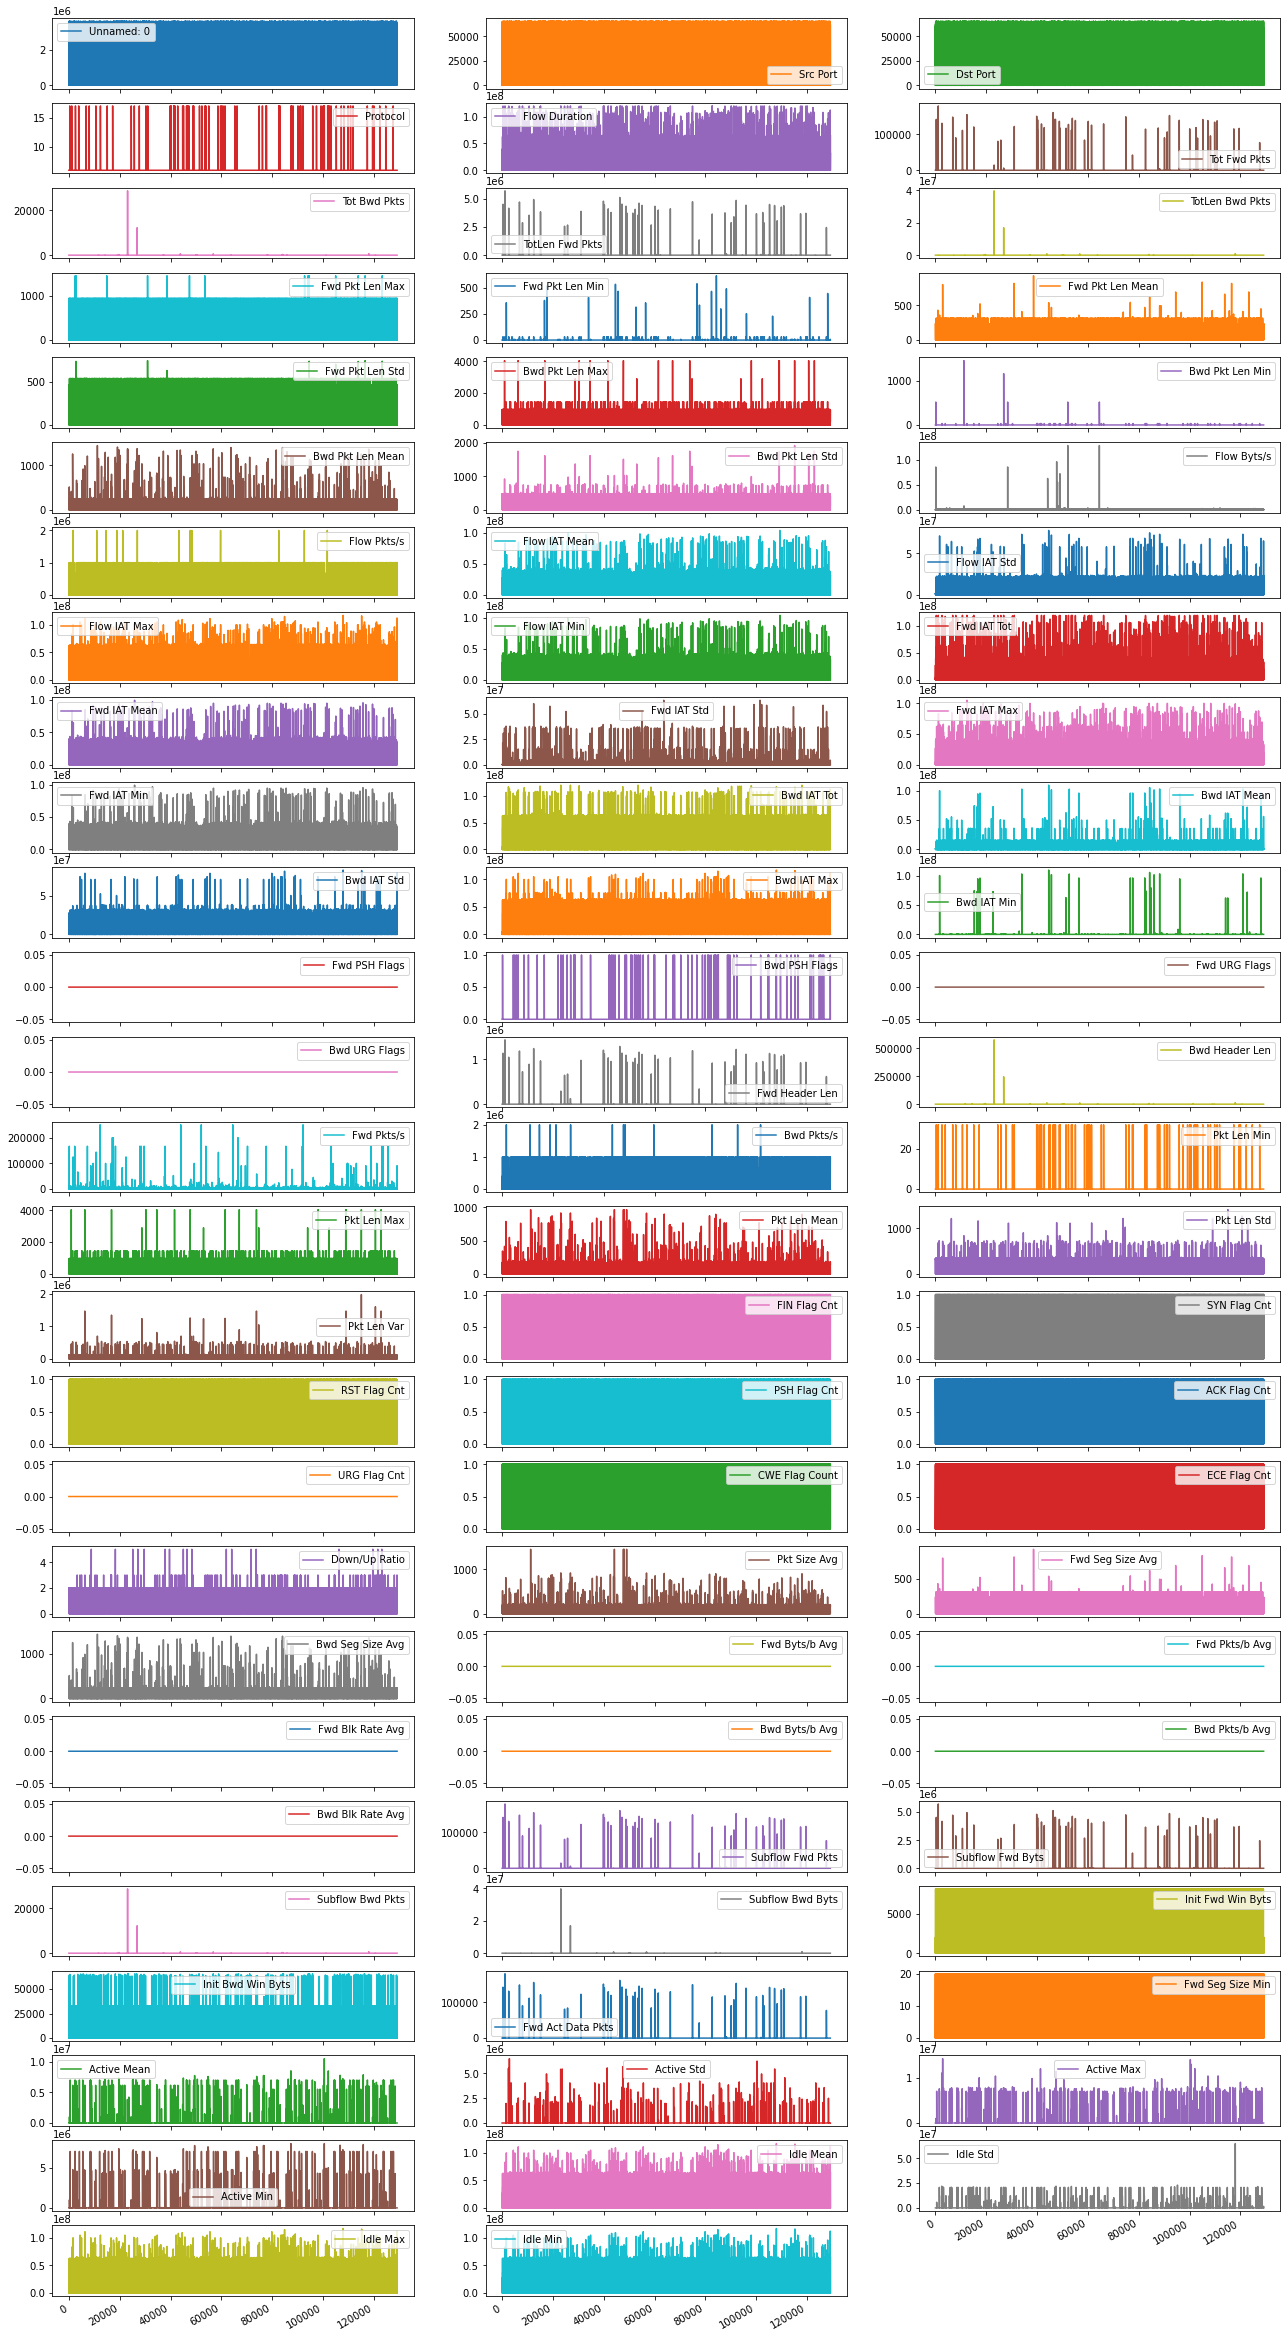

In [35]:
plotDf(dfddos, (29,3))

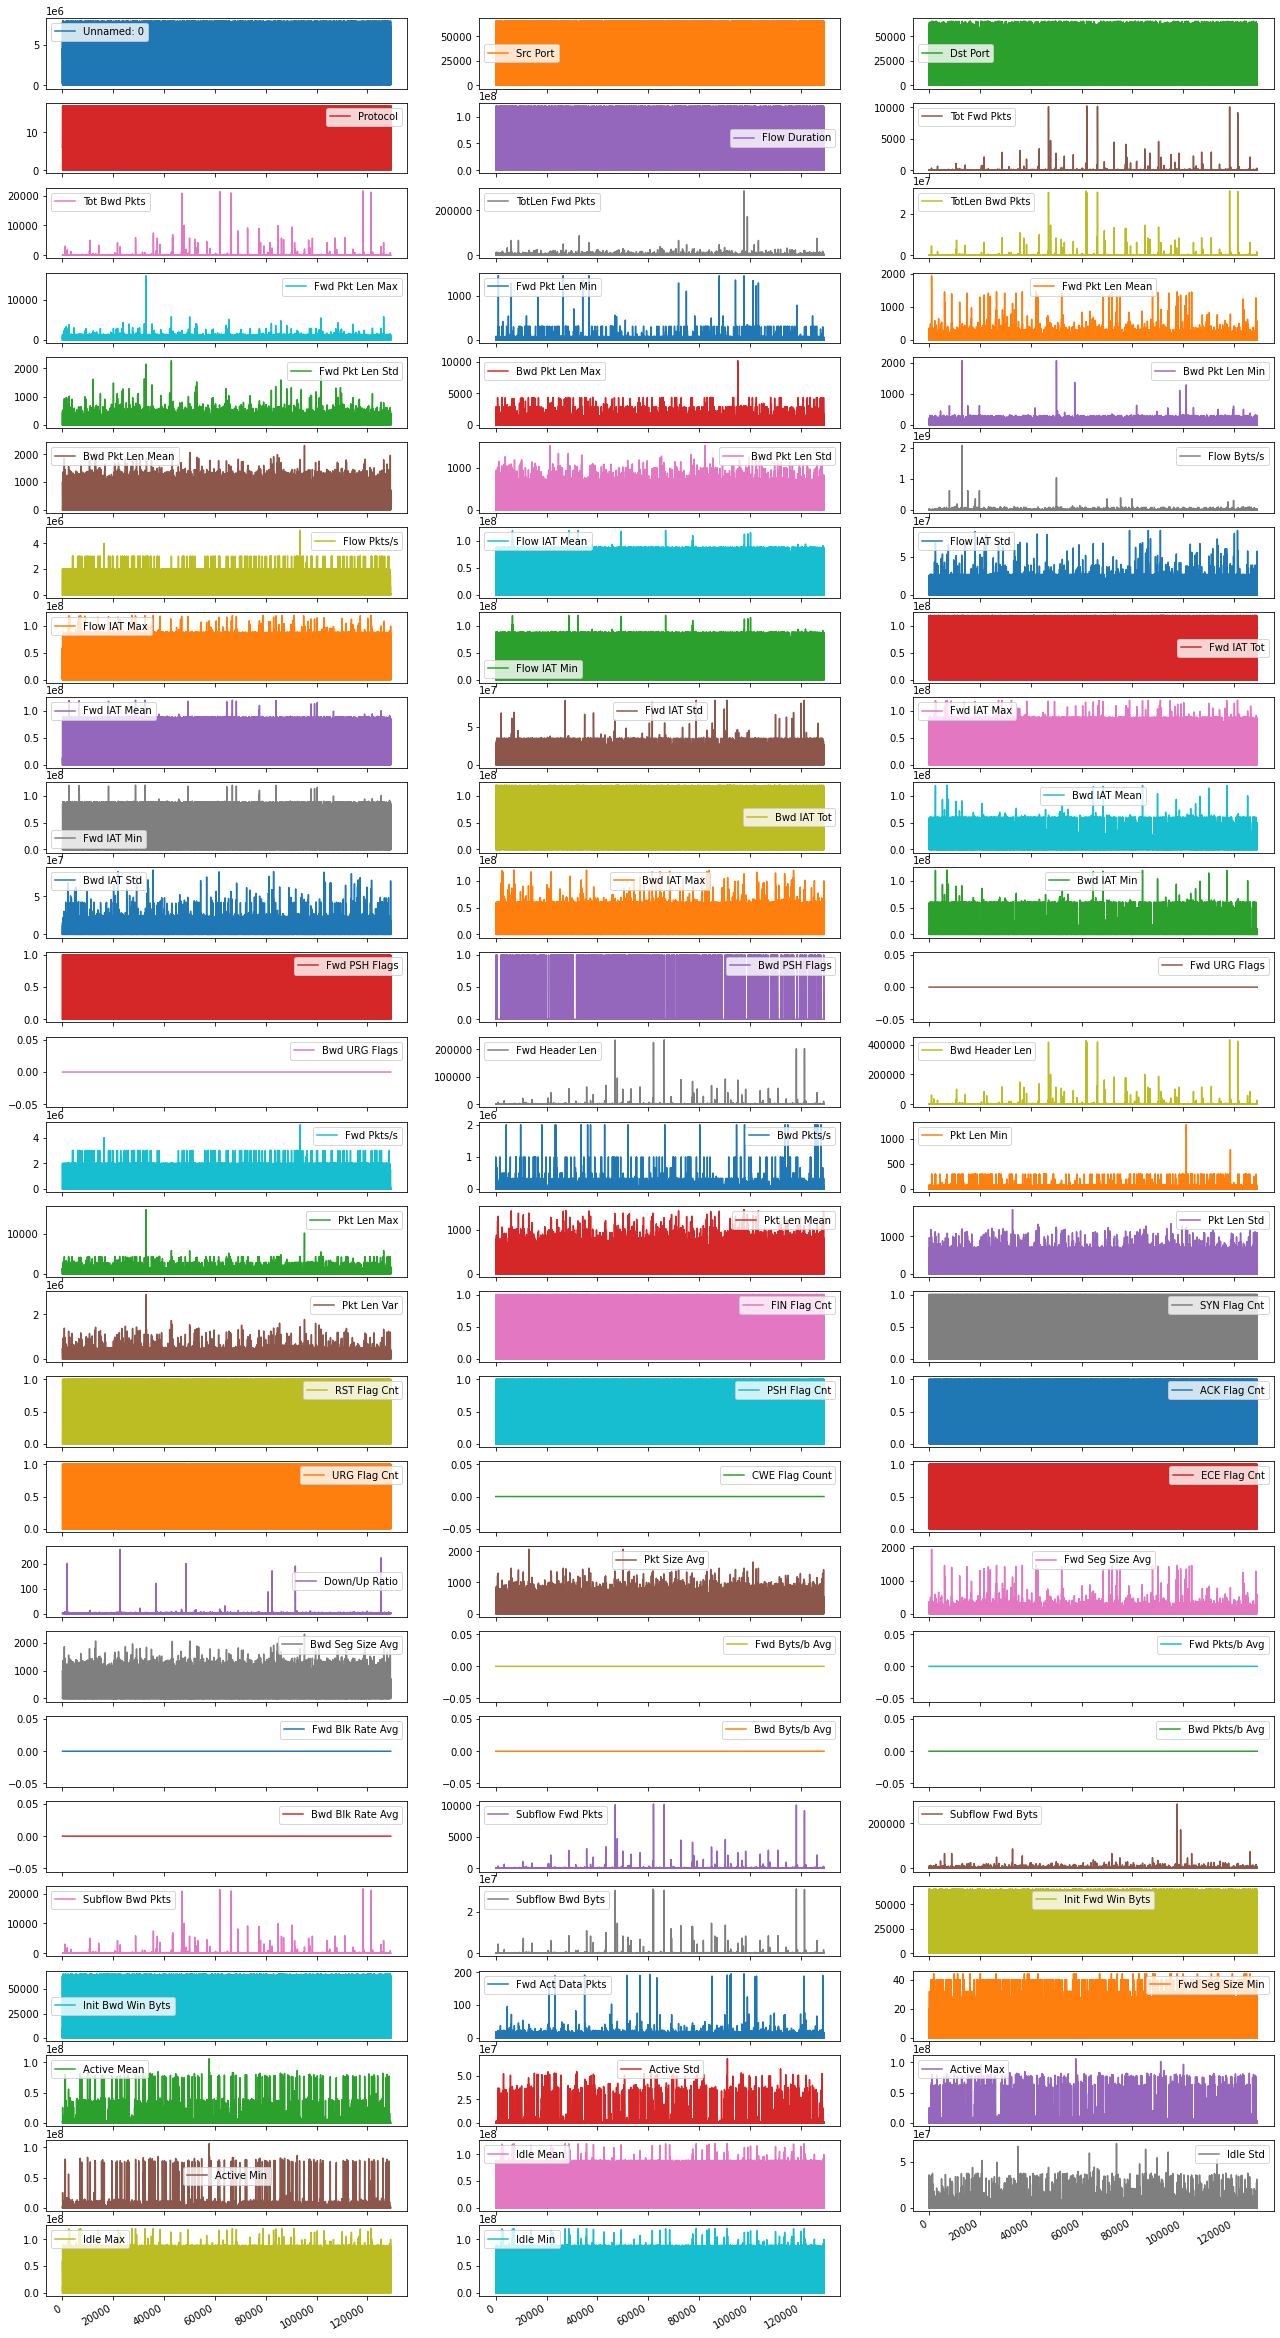

In [36]:
plotDf(dfbenign, (29,3))

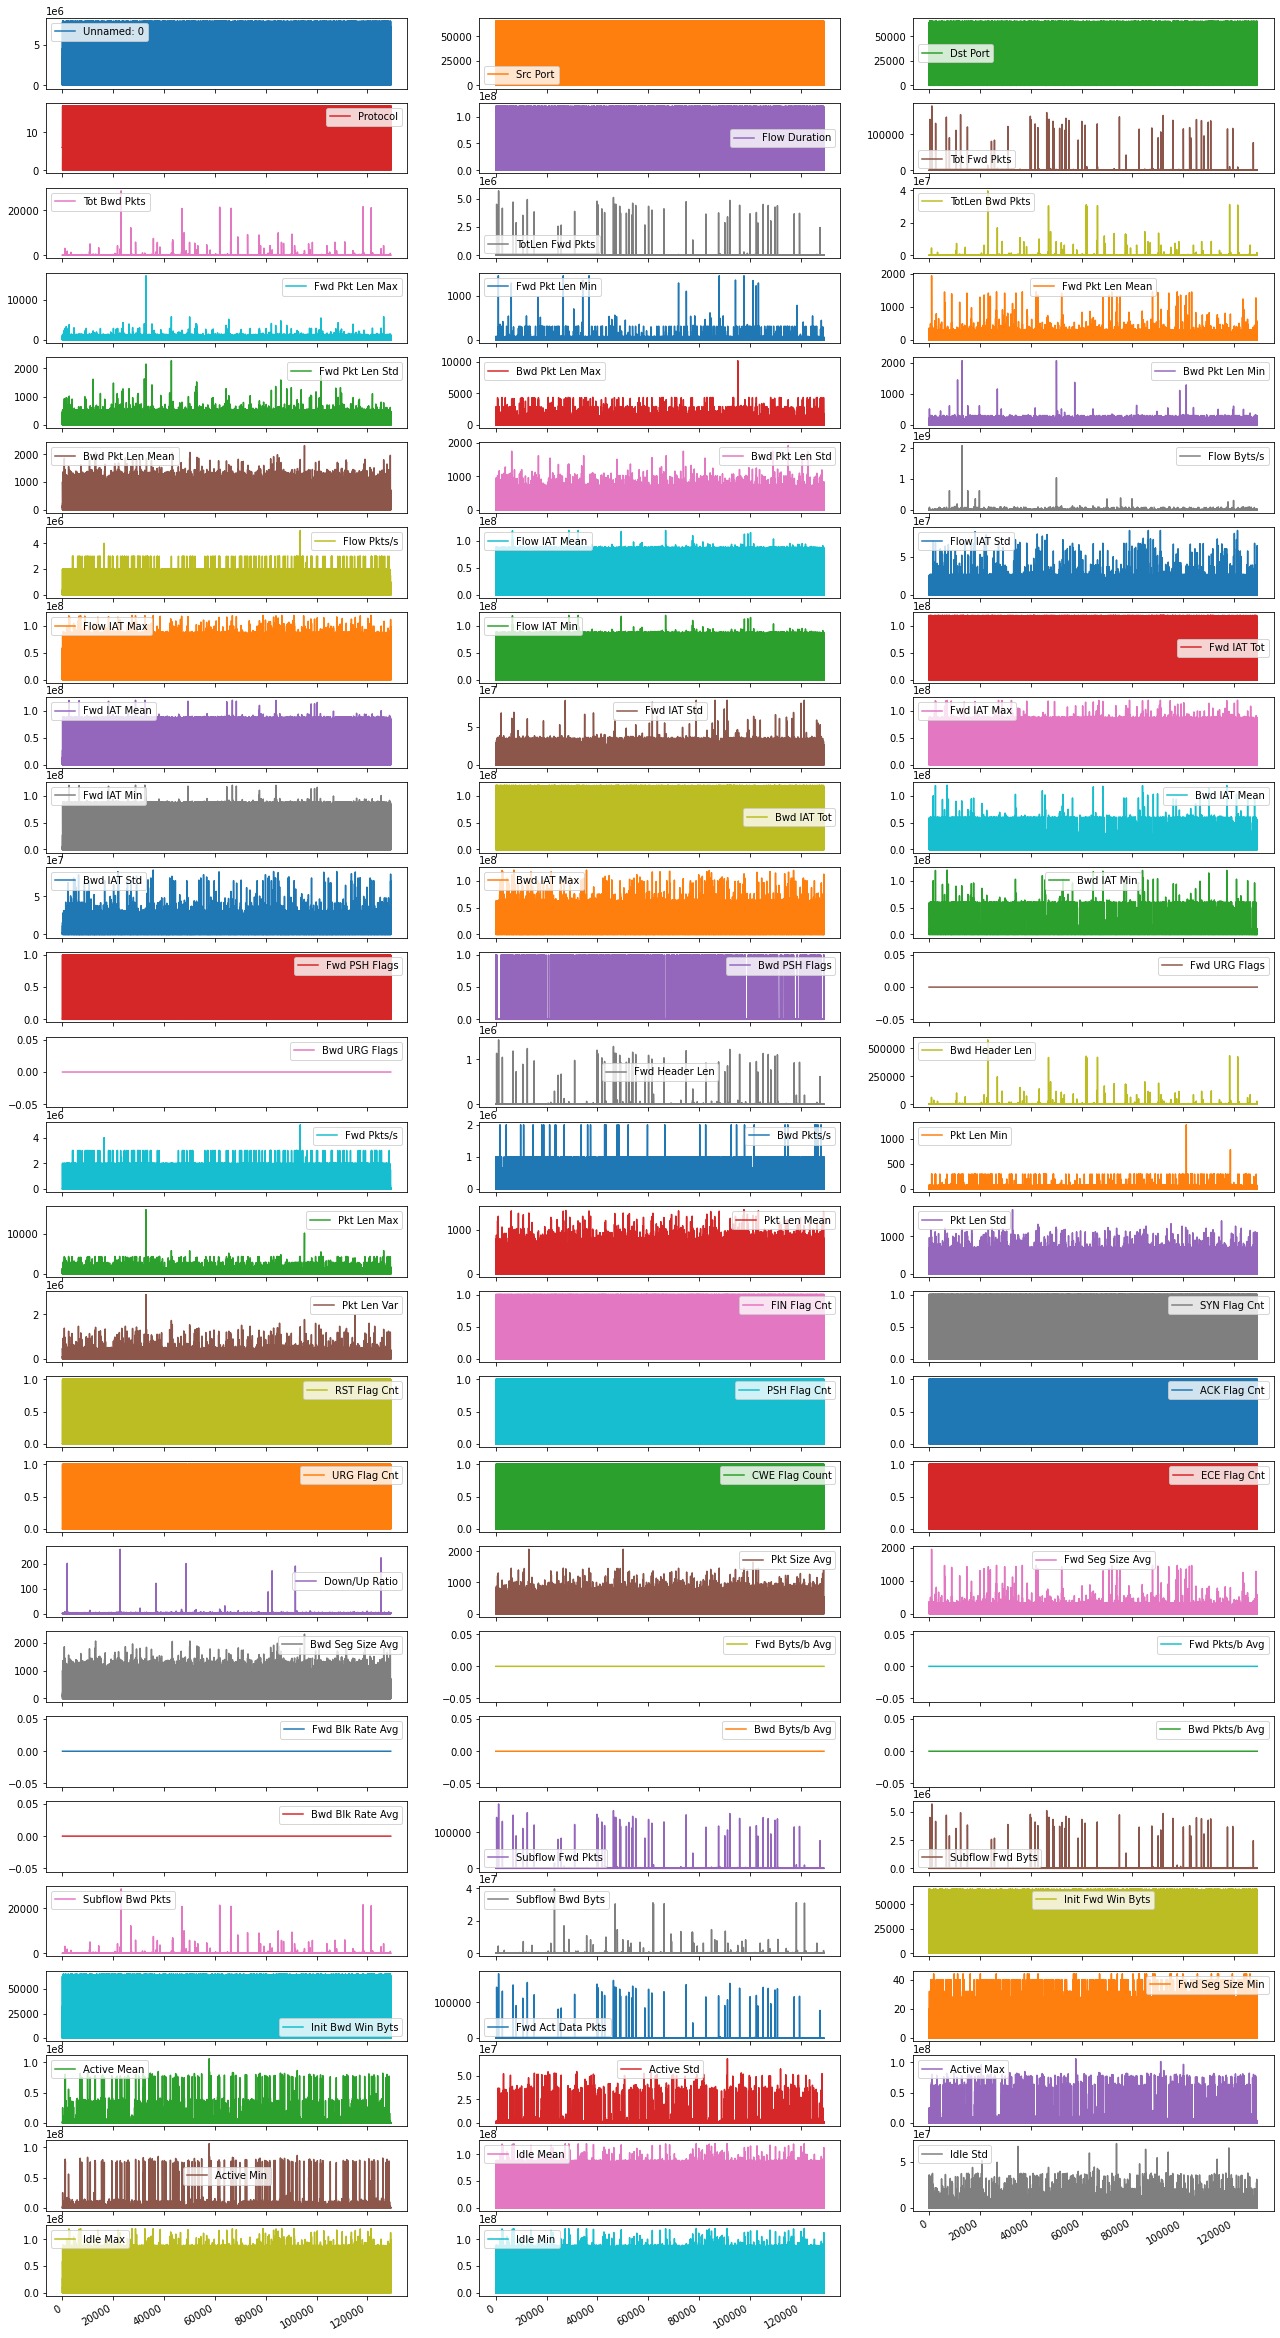

In [34]:
plotDf(df2, (29,3))

In [153]:
def ffb(feature):
    return feature.value_counts()/len(dfbenign)
def ffd(feature):
    return feature.value_counts()/len(dfddos)

In [154]:
df2[['FIN Flag Cnt', 'SYN Flag Cnt','RST Flag Cnt', 'PSH Flag Cnt', 
     'ACK Flag Cnt', 'URG Flag Cnt','CWE Flag Count', 'ECE Flag Cnt']].apply(pd.Series.value_counts)

,FIN Flag Cnt,SYN Flag Cnt,RST Flag Cnt,PSH Flag Cnt,ACK Flag Cnt,URG Flag Cnt,CWE Flag Count,ECE Flag Cnt
0,254280,223257,229500,205941,127143,253300,236498,207968
1,4024,35047,28804,52363,131161,5004,21806,50336


In [155]:
dfbenign[['FIN Flag Cnt', 'SYN Flag Cnt','RST Flag Cnt', 'PSH Flag Cnt', 
     'ACK Flag Cnt', 'URG Flag Cnt','CWE Flag Count', 'ECE Flag Cnt']].apply(ffb)

,FIN Flag Cnt,SYN Flag Cnt,RST Flag Cnt,PSH Flag Cnt,ACK Flag Cnt,URG Flag Cnt,CWE Flag Count,ECE Flag Cnt
0,0.985947,0.925692,0.821908,0.639518,0.741839,0.961255,1.0,0.823394
1,0.014053,0.074308,0.178092,0.360482,0.258161,0.038745,NaN,0.176606


In [156]:
dfddos[['FIN Flag Cnt', 'SYN Flag Cnt','RST Flag Cnt', 'PSH Flag Cnt', 
     'ACK Flag Cnt', 'URG Flag Cnt','CWE Flag Count', 'ECE Flag Cnt']].apply(ffd)

,FIN Flag Cnt,SYN Flag Cnt,RST Flag Cnt,PSH Flag Cnt,ACK Flag Cnt,URG Flag Cnt,CWE Flag Count,ECE Flag Cnt
0,0.982896,0.802945,0.955068,0.955045,0.242606,1.0,0.83116,0.786864
1,0.017104,0.197055,0.044932,0.044955,0.757394,NaN,0.16884,0.213136


In [25]:
df[empties1].apply(pd.Series.value_counts)

KeyboardInterrupt: 

In [59]:
df2['Timestamp'].iloc[0]

'16/02/2018 11:17:23 PM'

In [73]:
pd.to_datetime(df2['Timestamp'].iloc[0])

Timestamp('2018-02-16 23:17:23')

In [26]:
# a = df2[['Timestamp']].apply(pd.to_datetime).apply(pd.Timestamp)

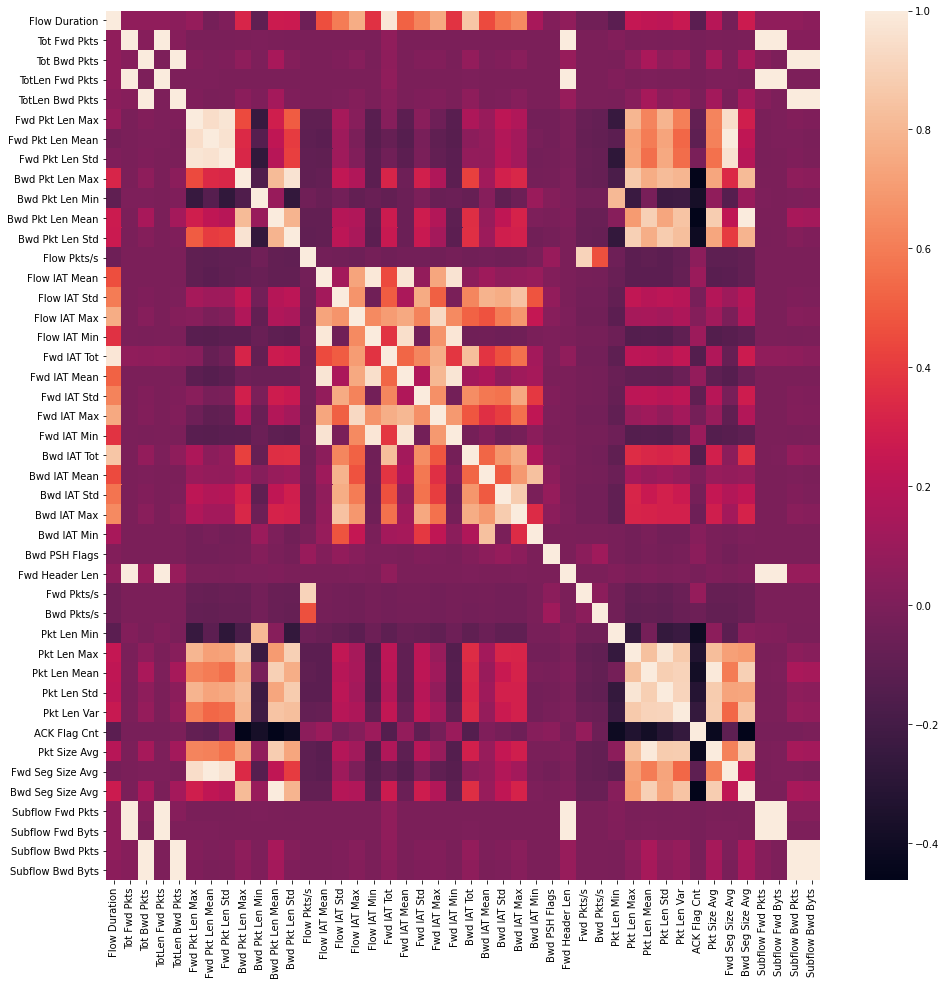

In [216]:
# rr = df2[['FIN Flag Cnt', 'SYN Flag Cnt','RST Flag Cnt', 'PSH Flag Cnt', 
#      'ACK Flag Cnt', 'URG Flag Cnt','CWE Flag Count', 'ECE Flag Cnt']]
# plotCorrelationMatrix(df3, 16)
plt.figure(figsize=(16,16))
sns.heatmap(df3.corr())
plt.show()

In [19]:
df4 = df3[['Pkt Len Min', 'Bwd PSH Flags', 'Bwd Pkt Len Min', 
'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Flow IAT Mean', 'Fwd IAT Mean', 'Fwd IAT Min',
'Fwd IAT Tot', 'Fwd IAT Std', 'Fwd IAT Max',
'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'ACK Flag Cnt', 'Label']]

In [20]:
df3.columns

Index(['Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'TotLen Fwd Pkts',
       'TotLen Bwd Pkts', 'Fwd Pkt Len Max', 'Fwd Pkt Len Mean',
       'Fwd Pkt Len Std', 'Bwd Pkt Len Max', 'Bwd Pkt Len Min',
       'Bwd Pkt Len Mean', 'Bwd Pkt Len Std', 'Flow Pkts/s', 'Flow IAT Mean',
       'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Tot',
       'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min',
       'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max',
       'Bwd IAT Min', 'Bwd PSH Flags', 'Fwd Header Len', 'Fwd Pkts/s',
       'Bwd Pkts/s', 'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean',
       'Pkt Len Std', 'Pkt Len Var', 'ACK Flag Cnt', 'Pkt Size Avg',
       'Fwd Seg Size Avg', 'Bwd Seg Size Avg', 'Subflow Fwd Pkts',
       'Subflow Fwd Byts', 'Subflow Bwd Pkts', 'Subflow Bwd Byts', 'Label'],
      dtype='object')

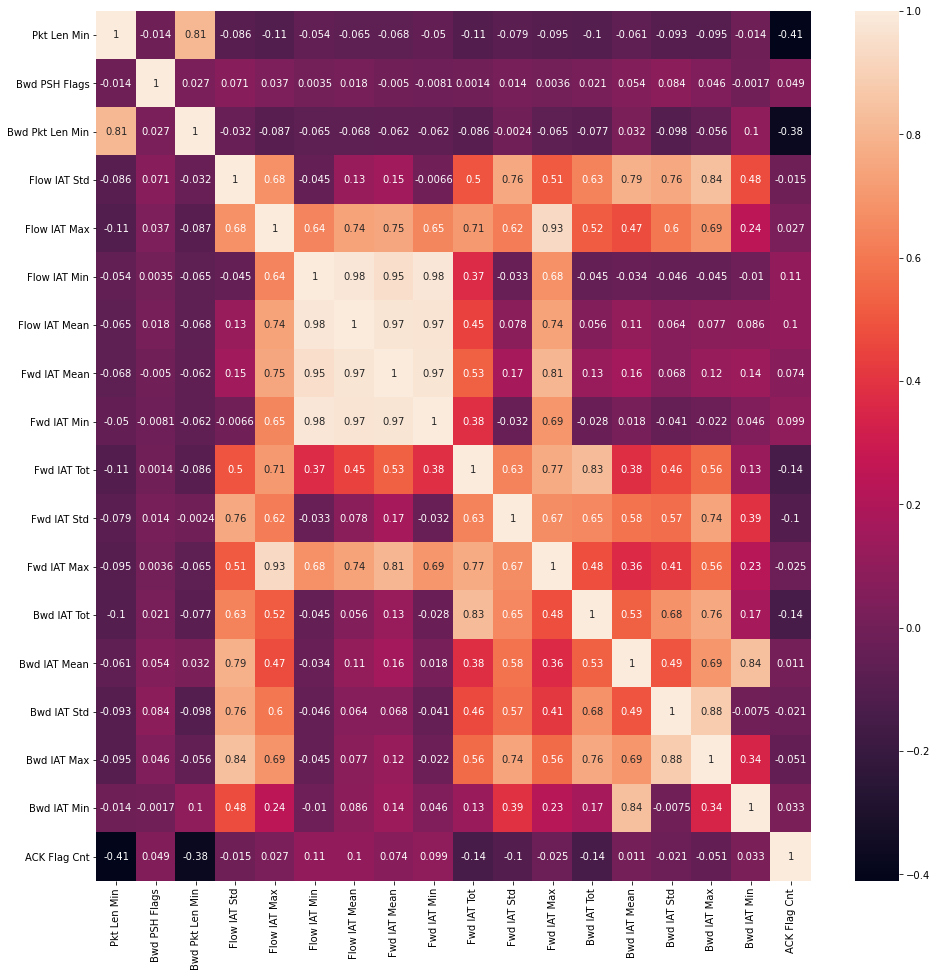

In [168]:
plt.figure(figsize=(16,16))
sns.heatmap(df4.corr(), annot=True)
plt.show()

In [21]:
df5 = df4[['Flow IAT Max', 'Flow IAT Std', 'Fwd IAT Tot', 'Fwd IAT Max', 'Bwd IAT Tot', 'Bwd IAT Max', 'Bwd IAT Std', 'Label']].reset_index(drop=True)

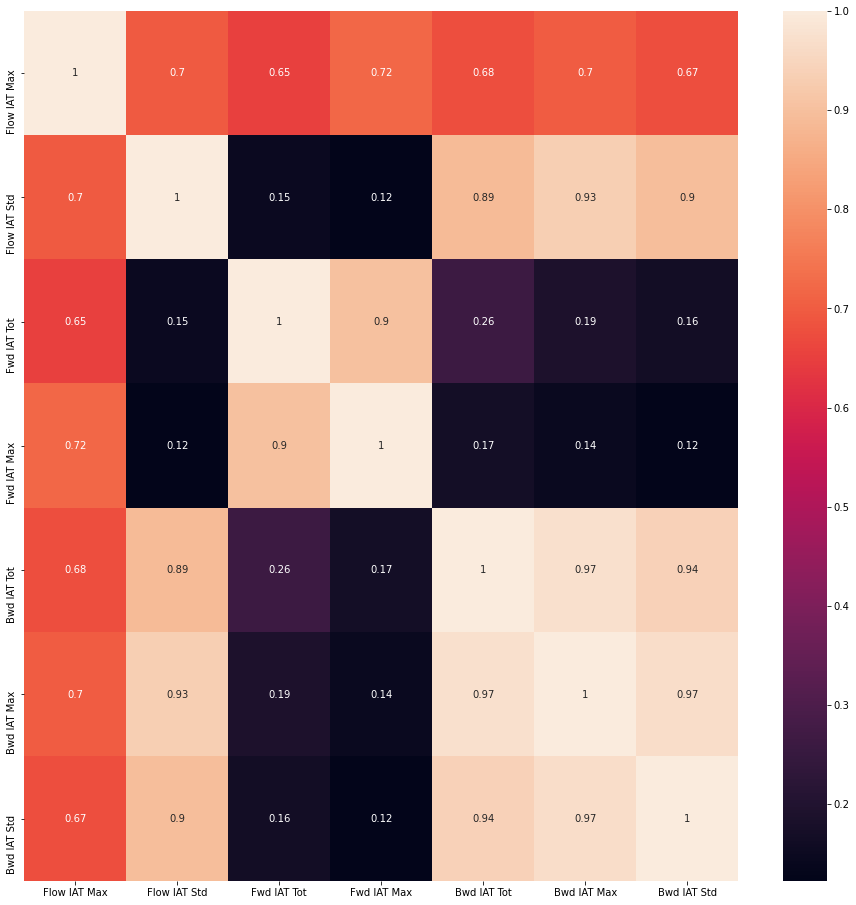

In [22]:
plt.figure(figsize=(16,16))
sns.heatmap(df5[df5['Label']=='ddos'].corr(), annot=True)
plt.show()

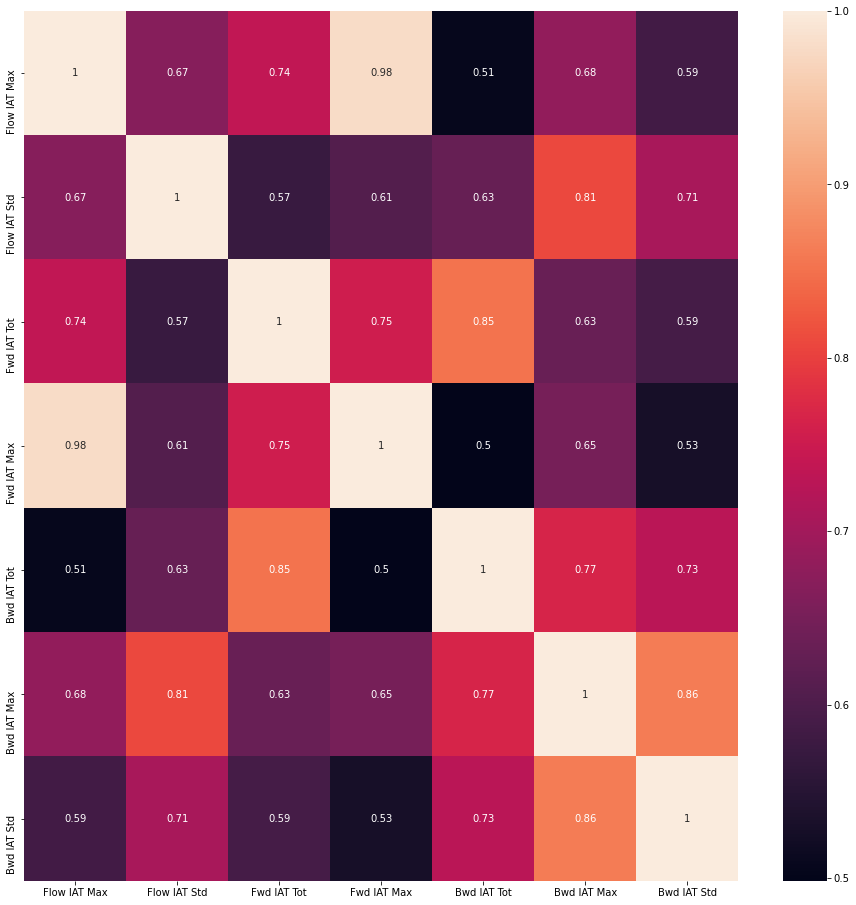

In [20]:
plt.figure(figsize=(16,16))
sns.heatmap(df5[df5['Label']=='Benign'].corr(), annot=True)
plt.show()

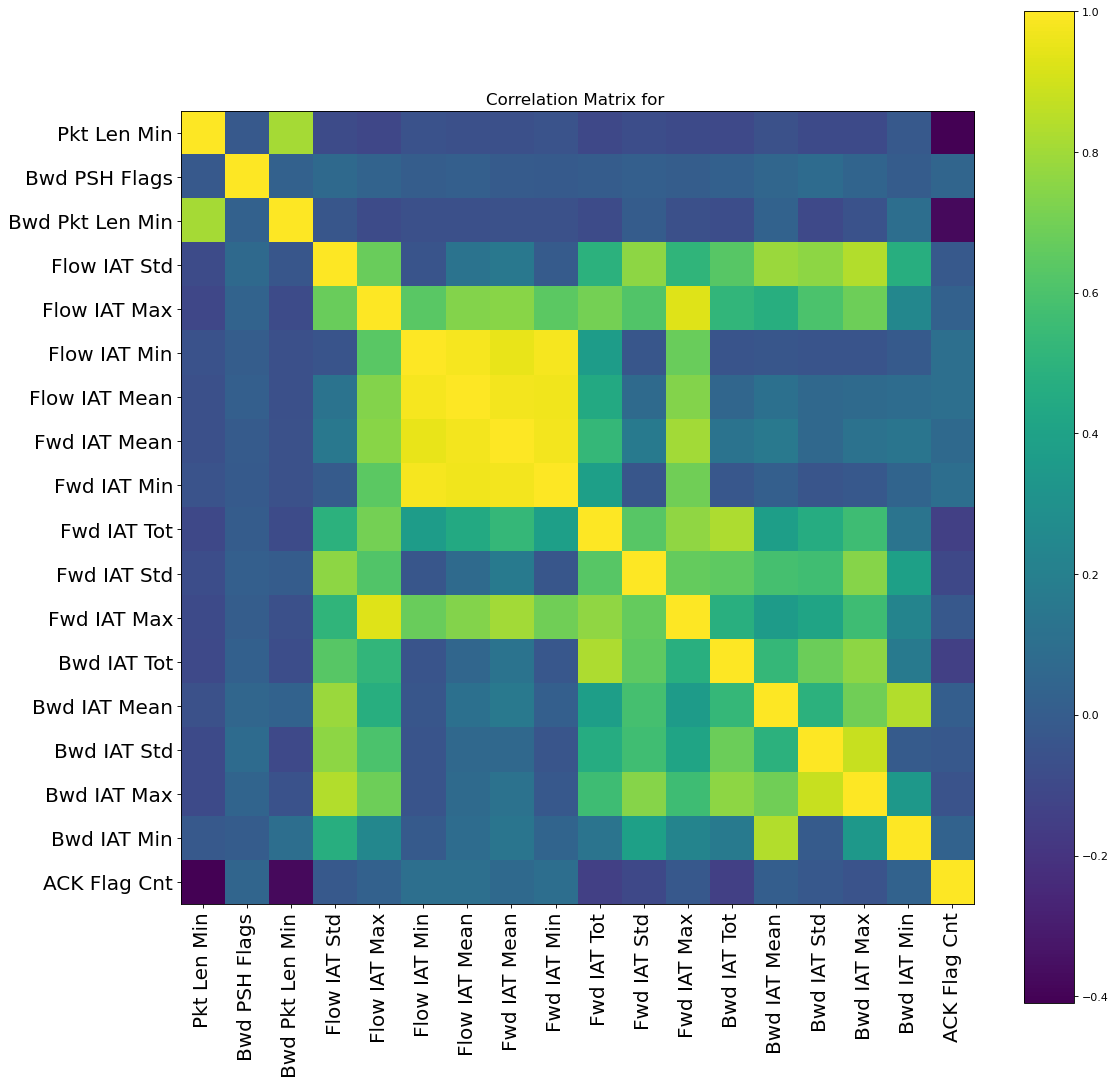

In [162]:
plotCorrelationMatrix(df4, 16)

In [196]:
[x for x in list(df2.columns) if x not in list(empties1)]

['Flow Duration',
 'Tot Fwd Pkts',
 'Tot Bwd Pkts',
 'TotLen Fwd Pkts',
 'TotLen Bwd Pkts',
 'Fwd Pkt Len Max',
 'Fwd Pkt Len Mean',
 'Fwd Pkt Len Std',
 'Bwd Pkt Len Max',
 'Bwd Pkt Len Min',
 'Bwd Pkt Len Mean',
 'Bwd Pkt Len Std',
 'Flow Pkts/s',
 'Flow IAT Mean',
 'Flow IAT Std',
 'Flow IAT Max',
 'Flow IAT Min',
 'Fwd IAT Tot',
 'Fwd IAT Mean',
 'Fwd IAT Std',
 'Fwd IAT Max',
 'Fwd IAT Min',
 'Bwd IAT Tot',
 'Bwd IAT Mean',
 'Bwd IAT Std',
 'Bwd IAT Max',
 'Bwd IAT Min',
 'Bwd PSH Flags',
 'Fwd Header Len',
 'Fwd Pkts/s',
 'Bwd Pkts/s',
 'Pkt Len Min',
 'Pkt Len Max',
 'Pkt Len Mean',
 'Pkt Len Std',
 'Pkt Len Var',
 'Pkt Size Avg',
 'Fwd Seg Size Avg',
 'Bwd Seg Size Avg',
 'Subflow Fwd Pkts',
 'Subflow Fwd Byts',
 'Subflow Bwd Pkts',
 'Subflow Bwd Byts',
 'Label']

<Figure size 1152x1152 with 0 Axes>

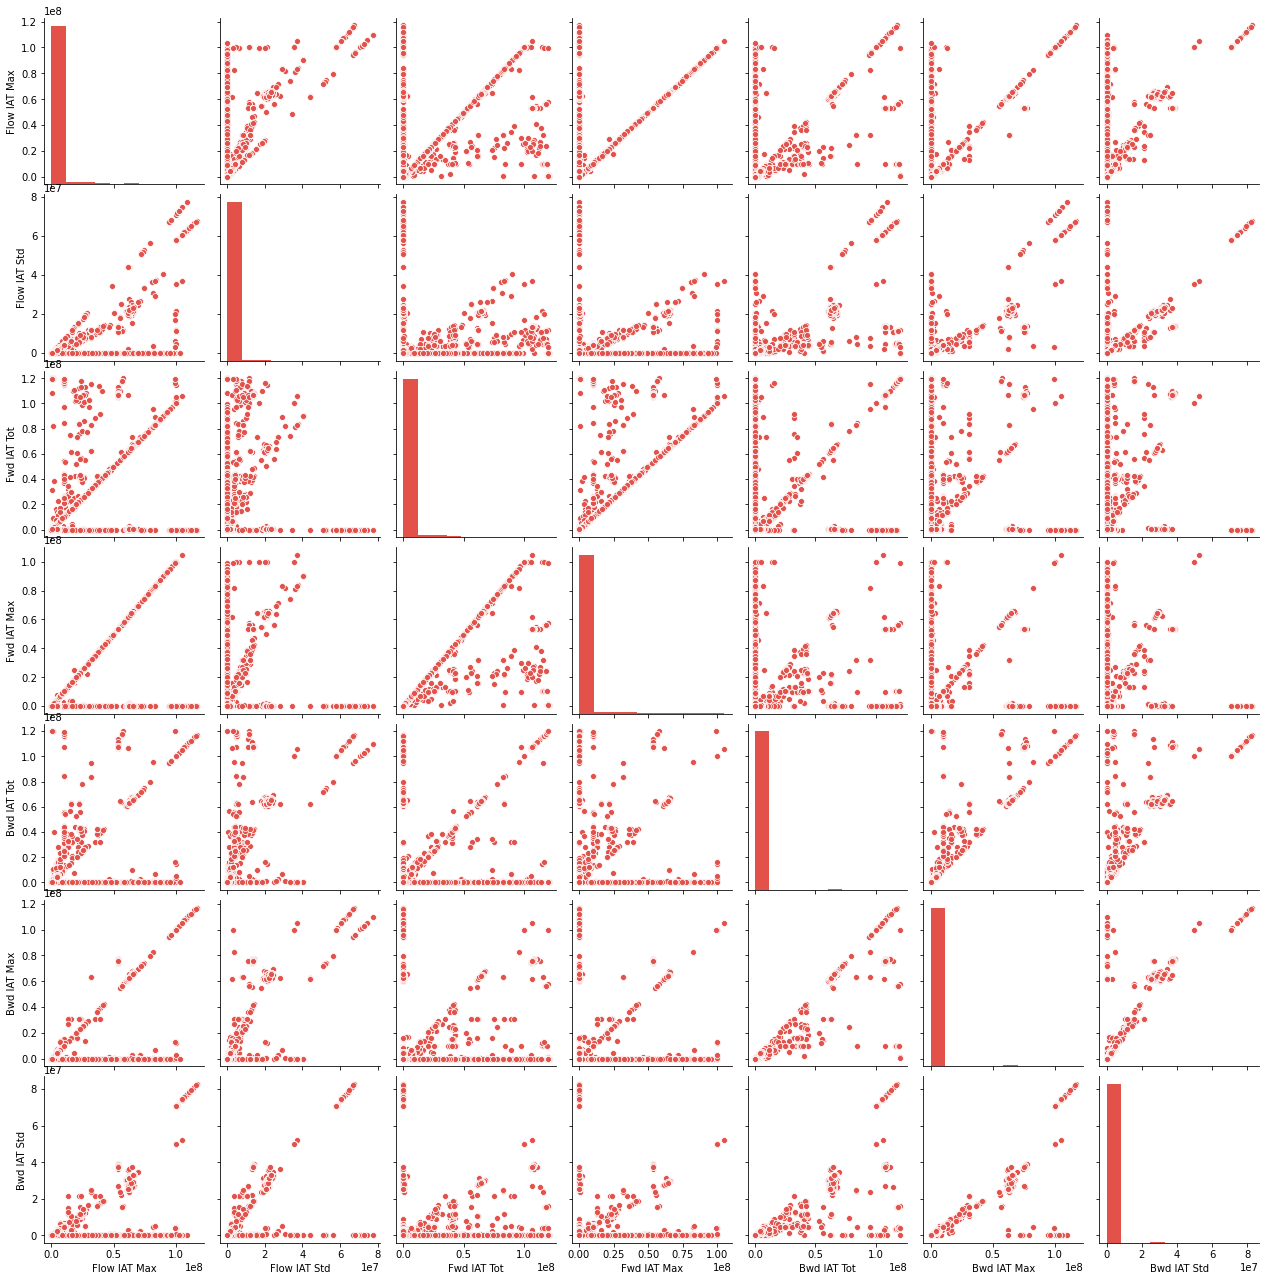

In [270]:
plt.figure(figsize=(16,16))
sns.pairplot(df5[df5['Label']=='ddos'])
plt.show()

<Figure size 1152x1152 with 0 Axes>

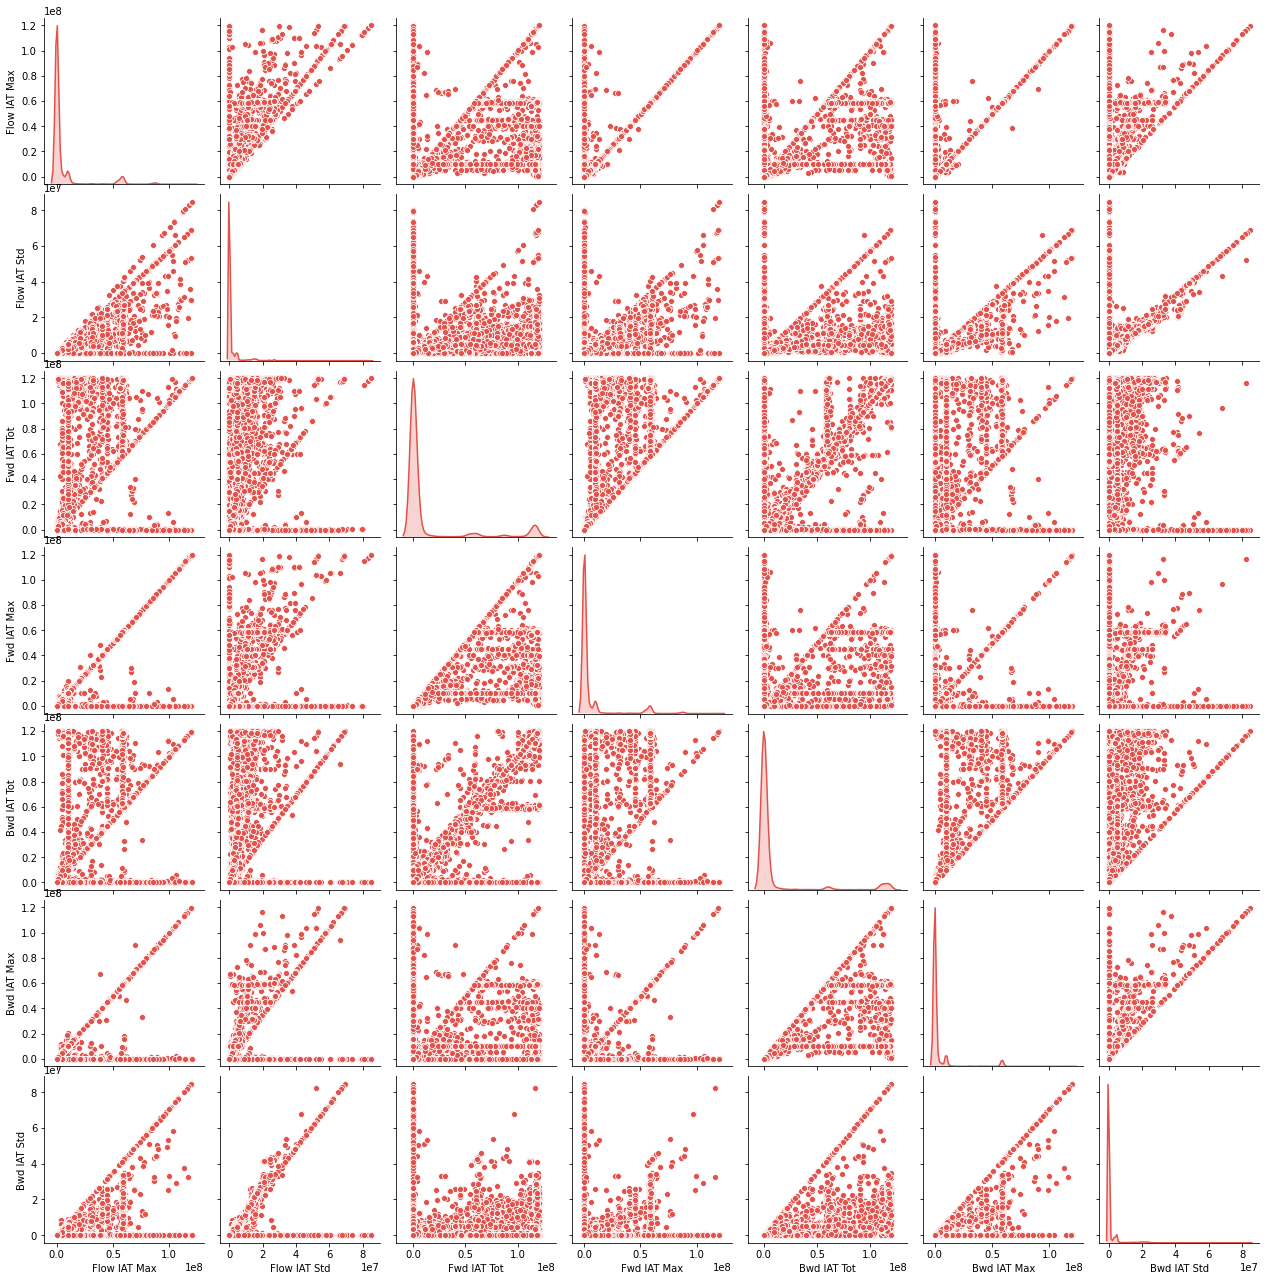

In [273]:
plt.figure(figsize=(16,16))
sns.pairplot(df5[df5['Label']=='Benign'], diag_kind='kde')
plt.show()

# Training

In [23]:
from sklearn import svm
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans
from fcmeans import FCM
from sklearn.metrics import roc_curve

from mpl_toolkits.mplot3d import Axes3D

import graphviz 
from sklearn import tree

In [24]:
df5

,Flow IAT Max,Flow IAT Std,Fwd IAT Tot,Fwd IAT Max,Bwd IAT Tot,Bwd IAT Max,Bwd IAT Std,Label
0,3978389.0,1.497744e+06,97011.0,54875.0,4033267.0,3978389.0,2.281221e+06,ddos
1,41908.0,0.000000e+00,0.0,0.0,0.0,0.0,0.000000e+00,ddos
2,14052.0,0.000000e+00,0.0,0.0,0.0,0.0,0.000000e+00,ddos
3,3237488.0,1.218894e+06,76877.0,60571.0,3298065.0,3237488.0,1.851689e+06,ddos
4,92681.0,3.776267e+04,93594.0,92998.0,92998.0,92681.0,6.531121e+04,ddos
...,...,...,...,...,...,...,...,...
258299,10010237.0,4.969921e+06,45389692.0,10031059.0,40124019.0,10031088.0,1.198370e+02,Benign
258300,1223084.0,3.532656e+05,2711870.0,1223084.0,2591934.0,1281050.0,5.423767e+05,Benign
258301,140249.0,8.097164e+04,0.0,0.0,140253.0,140250.0,9.916960e+04,Benign
258302,56318626.0,4.030509e+01,112637195.0,56318626.0,0.0,0.0,0.000000e+00,Benign


In [25]:
def standardDevNormalization(array):
    result = []
    vstd = array.std()
    vmean = array.mean()
    
    for i, v_i in enumerate(array):
        result.append((v_i - vmean)/(2*vstd))
    return result

In [26]:
# df5.loc[:, df5.columns != 'Label'].apply(standardDevNormalization).describe()

In [27]:
# df6 = normalize(df5.loc[:, df5.columns != 'Label'])
df6 = df5.loc[:, df5.columns != 'Label'].apply(standardDevNormalization)

In [60]:
df6.values

array([[-0.0147042 ,  0.07956408, -0.14499248, ..., -0.04211703,
         0.07133541,  0.16977413],
       [-0.16557596, -0.14000508, -0.14695976, ..., -0.1358634 ,
        -0.13726869, -0.14018898],
       [-0.16664359, -0.14000508, -0.14695976, ..., -0.1358634 ,
        -0.13726869, -0.14018898],
       ...,
       [-0.16180689, -0.12813464, -0.14695976, ..., -0.13260346,
        -0.12991478, -0.12671422],
       [ 1.99131685, -0.13999917,  2.13721038, ..., -0.1358634 ,
        -0.13726869, -0.14018898],
       [-0.16716958, -0.14000508, -0.14695976, ..., -0.1358634 ,
        -0.13726869, -0.14018898]])

In [61]:
df5.Label = df.Label.map({'ddos':0, 'Benign':1})
df5.Label.iloc[0]

0

In [62]:
x = df6.values
y = df5.Label.values

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.90, random_state=42)

In [63]:
len(x_train)

25830

In [235]:
import itertools
combs = list(itertools.combinations_with_replacement(['Flow IAT Max', 'Bwd IAT Tot', 'Fwd IAT Tot', 'Fwd IAT Max'], 3))

In [386]:
## best = ('Flow IAT Max', 'Bwd IAT Tot', 'Fwd IAT Tot') or ('Flow IAT Max', 'Bwd IAT Tot', 'Fwd IAT Max')
for comb in combs:
    df7 = df6[list(comb)]
    x = df7.values
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.90, random_state=42)
    clf = clf.fit(x_train[100:1500], y_train[100:1500])
    y_pred = clf.predict(x_test)
    print(comb)
    print('*'*70)
    print(classification_report(y_test, y_pred))
    print('*'*70)
    print()

KeyboardInterrupt: 

In [40]:
# x = df6[['Flow IAT Max', 'Bwd IAT Tot']].values
# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.90, random_state=42)

In [64]:
clf = tree.DecisionTreeClassifier()
# clf = clf.fit(x_train[:100], y_train[:100])   ## 74, 76 f1
# clf = clf.fit(x_train[100:500], y_train[100:500]) ## 0.83, 0..83
# clf = clf.fit(x_train[100:1500], y_train[100:1500])  ##0.84, 0.84
# clf = clf.fit(x_train[200:500], y_train[200:500])
# clf = clf.fit(x_train, y_train) ## 0.84, 0.85 --> df6[['Flow IAT Max', 'Bwd IAT Tot']] test_size=0.90
# clf = clf.fit(x_train, y_train) ## 0.82, 0.85 --> df6[['Flow IAT Max', 'Bwd IAT Tot']] test_size=0.70
clf = clf.fit(x_train, y_train)

In [44]:
plt.figure(figsize=(26,26))
tree.plot_tree(clf, fontsize=2)
plt.show()

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x000001A8F34DD550> (for post_execute):


KeyboardInterrupt: 

In [65]:
y_pred = clf.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.88      0.89    116247
           1       0.88      0.91      0.90    116227

    accuracy                           0.89    232474
   macro avg       0.89      0.89      0.89    232474
weighted avg       0.89      0.89      0.89    232474



In [34]:
# fpr_dt, tpr_dt, _ = roc_curve(y_test, y_pred)

In [431]:
clf.get_n_leaves()

179

In [432]:
clf.get_depth()

20

In [290]:
x[0]

array([-0.0147042 , -0.04211703])

##  MLP

In [468]:
x_train, x_test_, y_train, y_test_ = train_test_split(x, y, test_size=0.50, random_state=42)


x_train, y_train = x_train, y_train

x_test, x_val = x_test_[:int(len(x_test_)/2)], x_test_[int(len(x_test_)/2):]

y_test, y_val = y_test_[:int(len(y_test_)/2)], y_test_[int(len(y_test_)/2):]

In [44]:
model, history = SimpleMLP(train=[x_train, y_train], val=[[], []], dropout=0.40, neuronsPerLayer=[8, 4, 4, 2], EPOCHS=20, BATCH_SIZE=32)

Epoch 1/20
808/808 [==============================] - 0s 461us/step - loss: 0.2668 - accuracy: 0.5293
Epoch 2/20
808/808 [==============================] - 0s 451us/step - loss: 0.2413 - accuracy: 0.5587
Epoch 3/20
808/808 [==============================] - 0s 471us/step - loss: 0.2388 - accuracy: 0.5666
Epoch 4/20
808/808 [==============================] - 0s 459us/step - loss: 0.2364 - accuracy: 0.5794
Epoch 5/20
808/808 [==============================] - 0s 443us/step - loss: 0.2333 - accuracy: 0.5890
Epoch 6/20
808/808 [==============================] - 0s 454us/step - loss: 0.2285 - accuracy: 0.5989
Epoch 7/20
808/808 [==============================] - 0s 459us/step - loss: 0.2269 - accuracy: 0.6088
Epoch 8/20
808/808 [==============================] - 0s 448us/step - loss: 0.2242 - accuracy: 0.6197
Epoch 9/20
808/808 [==============================] - 0s 450us/step - loss: 0.2204 - accuracy: 0.6243
Epoch 10/20
808/808 [==============================] - 0s 456us/step - loss: 0.225

In [45]:
Metriks_Multi(model, history.history, x_test, y_test, acc='accuracy', val_acc='val_accuracy', thresh=0.5)

7265/7265 [==============================] - 2s 335us/step - loss: 0.2219 - accuracy: 0.6197
Model Evaluation: loss ~ 22.19%
Model Evaluation: accuracy ~ 61.97%
------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.78      0.34      0.47    116247
           1       0.58      0.90      0.70    116227

    accuracy                           0.62    232474
   macro avg       0.68      0.62      0.59    232474
weighted avg       0.68      0.62      0.59    232474

------------------------------------------------------------------------------------------


NameError: name 'accuracy_score' is not defined

In [46]:
# y_pred = model.predict(x_test)
# y_pred[y_pred < .5] = 0
# y_pred[y_pred >= .5] = 1
# y_pred_ = y_pred

In [47]:
# fpr_mlp, tpr_mlp,_ =  roc_curve(y_test, y_pred_)

In [79]:
df6['Flow IAT Max'].min()

-0.16718215320202703

In [80]:
y_pred

array([1, 0, 1, ..., 1, 1, 1], dtype=int64)

In [256]:
fcm = FCM(n_clusters=2)
fcm.fit(x_train)

In [257]:
fcm.centers

array([[-0.10366738, -0.10397426],
       [ 1.55679851,  1.80447195]])

In [258]:
y_pred = fcm.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.53      0.99      0.69     64364
           1       0.91      0.11      0.20     64788

    accuracy                           0.55    129152
   macro avg       0.72      0.55      0.44    129152
weighted avg       0.72      0.55      0.44    129152



129152

In [35]:
kmeans = KMeans(n_clusters=2, n_init=1110, max_iter=2200, verbose=0, random_state=42).fit(x_test[100:1500])
kmeans.labels_


array([0, 1, 0, ..., 0, 0, 0])

In [36]:
y_pred = kmeans.predict(x_test)
print(classification_report(y_test, y_pred))
# kmeans.cluster_centers_

              precision    recall  f1-score   support

           0       0.51      0.99      0.67    116247
           1       0.83      0.04      0.08    116227

    accuracy                           0.52    232474
   macro avg       0.67      0.52      0.38    232474
weighted avg       0.67      0.52      0.38    232474



In [37]:
# fpr_km, tpr_km, _ = roc_curve(y_test, y_pred)

[[102590  13657]
 [ 10931 105296]]


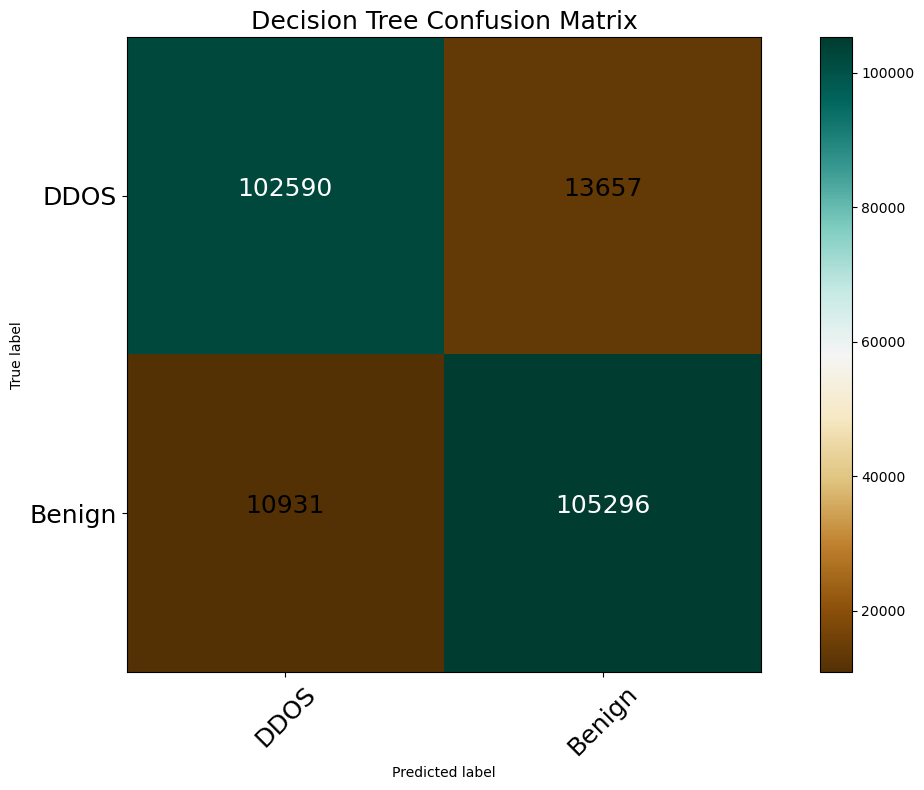

In [436]:
cmap=plt.cm.BrBG
labelS = [0, 1]
labelS2 = ['DDOS', 'Benign']
cm = confusion_matrix(y_test, y_pred, labels=labelS)
# if normalize:
#         cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
# else:
#     print('Confusion matrix, without normalization')

print(cm)
plt.figure(figsize=(12,8))
plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.title('Decision Tree Confusion Matrix', fontsize=18 )
plt.colorbar()
tick_marks = np.arange(len(labelS2))
plt.xticks(tick_marks, labelS2, rotation=45, fontsize=18)
plt.yticks(tick_marks, labelS2, fontsize=18)

fmt = 'd'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt), fontsize=18,
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()

In [103]:
y_test

array([1, 0, 1, ..., 1, 0, 1], dtype=int64)

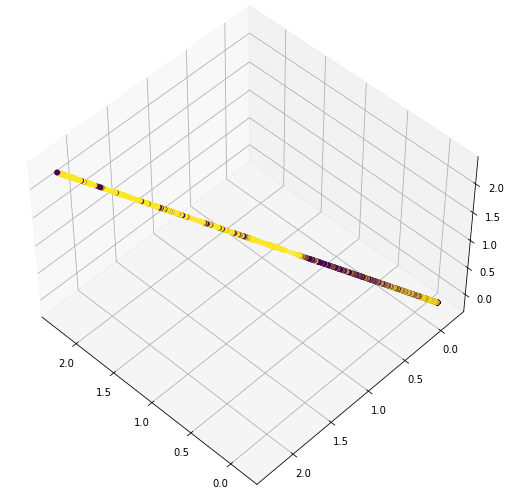

In [125]:
fig = plt.figure(figsize=(7, 7))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

ax.scatter(x_test[:, 0], x_test[:,1], x_test[:,2], c=y_test)
plt.show()

- x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.90, random_state=42)
- KMeans(n_clusters=2, random_state=0).fit(x_test)

                  precision    recall  f1-score   support

               0       0.53      0.98      0.69    116247
               1       0.86      0.12      0.22    116227

          accuracy                           0.55    232474
    
         macro avg       0.70      0.55      0.45    232474
   
      weighted avg       0.70      0.55      0.45    232474


In [43]:
# params = {'max_iter': 10, 'verbose':True}

In [33]:
# model = svm.SVC(cache_size=7000, verbose=True)#kernel='rbf')
model = make_pipeline(StandardScaler(), svm.SVC(gamma='auto'))

In [34]:
model.fit(x_train, y_train.ravel())

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(gamma='auto'))])

In [35]:
model.predict(x_test)

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [117]:
from sklearn.svm import LinearSVC
clf = LinearSVC(random_state=0, tol=1e-5)
clf.fit(x_train, y_train) 

TypeError: __init__() got an unexpected keyword argument 'cache_size'

In [116]:
clf.predict(x_test)

array([0, 0, 1, ..., 0, 0, 0], dtype=int64)

In [38]:
model2 = svm.SVC(C=1000, kernel='linear')#kernel='rbf')

In [39]:
model2.fit(x_train[100:1500], y_train[100:1500])

SVC(C=1000, kernel='linear')

In [40]:
y_true, y_pred = y_test, model2.predict(x_test)
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.59      0.98      0.74    116247
           1       0.95      0.32      0.48    116227

    accuracy                           0.65    232474
   macro avg       0.77      0.65      0.61    232474
weighted avg       0.77      0.65      0.61    232474



In [41]:
fpr_svm, tpr_svm, _ = roc_curve(y_true, y_pred)

In [367]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC

print(__doc__)



# Set the parameters by cross-validation
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

# scores = ['precision', 'recall', 'f1']
scores = ['f1']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(
        SVC(cache_size=16000), tuned_parameters, scoring='%s_macro' % score
    )
    clf.fit(x_train[100:1500], y_train[100:1500])

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(x_test)
    print(classification_report(y_true, y_pred))
    print()


Automatically created module for IPython interactive environment
# Tuning hyper-parameters for f1

Best parameters set found on development set:

{'C': 1000, 'kernel': 'linear'}

Grid scores on development set:

0.341 (+/-0.000) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.341 (+/-0.000) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.449 (+/-0.025) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.341 (+/-0.000) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.534 (+/-0.116) for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
0.449 (+/-0.025) for {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
0.584 (+/-0.040) for {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
0.503 (+/-0.104) for {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
0.584 (+/-0.036) for {'C': 1, 'kernel': 'linear'}
0.585 (+/-0.036) for {'C': 10, 'kernel': 'linear'}
0.589 (+/-0.037) for {'C': 100, 'kernel': 'linear'}
0.603 (+/-0.045) for {'C': 1000, 'kernel': 'linear'}

Detailed classification report:

The model is trained on the 

In [ ]:
8

In [173]:
df3

,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,Bwd Pkt Len Min,...,Pkt Len Var,ACK Flag Cnt,Pkt Size Avg,Fwd Seg Size Avg,Bwd Seg Size Avg,Subflow Fwd Pkts,Subflow Fwd Byts,Subflow Bwd Pkts,Subflow Bwd Byts,Label
0,4075407,4,4,935.0,350.0,935.0,233.750000,467.500000,350.0,0.0,...,101656.944444,1,160.625000,233.750000,87.500000,4,935,4,350,ddos
1,41908,1,1,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.000000,1,0.000000,0.000000,0.000000,1,0,1,0,ddos
2,14052,1,1,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.000000,1,0.000000,0.000000,0.000000,1,0,1,0,ddos
3,3314380,4,4,935.0,369.0,935.0,233.750000,467.500000,369.0,0.0,...,102681.361111,1,163.000000,233.750000,92.250000,4,935,4,369,ddos
4,93598,4,3,935.0,339.0,935.0,233.750000,467.500000,339.0,0.0,...,112323.071429,0,182.000000,233.750000,113.000000,4,935,3,339,ddos
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129147,45389692,6,5,5.0,0.0,1.0,0.833333,0.408248,0.0,0.0,...,0.272727,1,0.545455,0.833333,0.000000,6,5,5,0,Benign
129148,2711870,11,7,1148.0,1581.0,677.0,104.363636,202.294475,1173.0,0.0,...,89114.356725,0,151.611111,104.363636,225.857143,11,1148,7,1581,Benign
129149,140253,1,3,29.0,187.0,29.0,29.000000,0.000000,79.0,29.0,...,750.000000,0,61.250000,29.000000,62.333333,1,29,3,187,Benign
129150,112637195,3,0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.000000,0,0.000000,0.000000,0.000000,3,0,0,0,Benign


# preprocessing

##  pca

In [218]:
dfPCA = df3.loc[:, df3.columns != 'Label'].apply(standardDevNormalization).dropna(axis=1)
dfpcaValues = dfPCA.values
# dfPCA = df3.drop(['Label'], axis=1).values
pca = PCA(n_components=3)
pca.fit(dfpcaValues)

print(pca.explained_variance_ratio_)

print(pca.singular_values_)

[0.25210892 0.16899702 0.11680526]
[836.68708766 685.0282477  569.50844037]


In [209]:
dfpcaValues

array([[-8.46792187e-02, -6.88382780e-03, -4.20480300e-03, ...,
        -1.85129014e-03, -4.20480300e-03, -7.47102112e-03],
       [-1.65612804e-01, -7.75310860e-03, -1.48773577e-02, ...,
        -1.03220845e-02, -1.48773577e-02, -8.34057852e-03],
       [-1.66171745e-01, -7.75310860e-03, -1.48773577e-02, ...,
        -1.03220845e-02, -1.48773577e-02, -8.34057852e-03],
       ...,
       [-1.63639477e-01, -7.75310860e-03, -7.76232125e-03, ...,
        -1.00593540e-02, -7.76232125e-03, -7.87598642e-03],
       [ 2.09365150e+00, -7.17358807e-03, -1.84348760e-02, ...,
        -1.03220845e-02, -1.84348760e-02, -8.34057852e-03],
       [-1.66447122e-01, -7.75310860e-03, -1.48773577e-02, ...,
        -9.90533954e-03, -1.48773577e-02, -8.18654263e-03]])

In [212]:
pca.fit_transform(dfpcaValues).shape

(258304, 1)

In [220]:
pd.DataFrame(pca.components_,columns=dfPCA.columns,index = ['PC-1','PC-2','PC-3'])

,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,Bwd Pkt Len Min,...,Pkt Len Std,Pkt Len Var,ACK Flag Cnt,Pkt Size Avg,Fwd Seg Size Avg,Bwd Seg Size Avg,Subflow Fwd Pkts,Subflow Fwd Byts,Subflow Bwd Pkts,Subflow Bwd Byts
PC-1,0.158643,0.001975,0.040000,0.003042,0.034924,0.205965,0.182758,0.182842,0.252095,-0.048099,...,0.276843,0.265164,-0.102802,0.262267,0.182758,0.238348,0.001975,0.003042,0.040000,0.034924
PC-2,0.267592,0.014052,-0.002030,0.013042,-0.002297,-0.139366,-0.155546,-0.146041,-0.058863,-0.003378,...,-0.123157,-0.093649,0.053543,-0.115664,-0.155546,-0.057808,0.014052,0.013042,-0.002030,-0.002297
PC-3,0.018422,0.441800,0.071163,0.439685,0.071375,-0.011276,-0.010319,-0.013252,-0.001738,0.011355,...,-0.006877,-0.001678,-0.014760,0.005509,-0.010319,0.008859,0.441800,0.439685,0.071163,0.071375


In [195]:
np.argsort(pca.explained_variance_ratio_)

array([42, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27, 26,
       25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10,  9,
        8,  7,  6,  5,  4,  3,  2,  1,  0], dtype=int64)

In [196]:
pca.explained_variance_ratio_[42]

1.3834768842987979e-33

In [187]:
test = df3.loc[:, df3.columns != 'Label'].apply(standardDevNormalization)

In [190]:
fpr_mlp, tpr_mlp, _ = roc_curve(y_test, y_pred)
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_pred)

fpr_dt, tpr_dt, _ = roc_curve(y_test, y_pred)

258304

### ROC

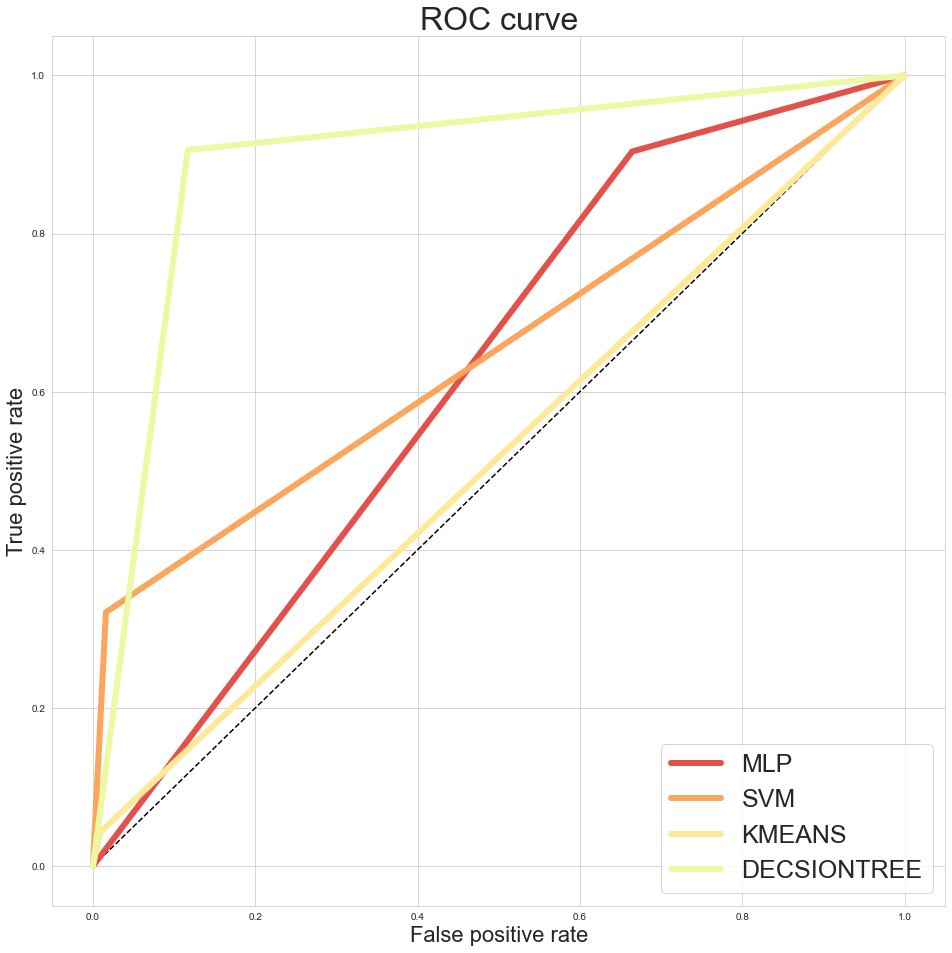

In [56]:
plt.figure(figsize=(16,16))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_mlp, tpr_mlp, label='MLP', linewidth=6)
plt.plot(fpr_svm, tpr_svm, label='SVM', linewidth=6)
plt.plot(fpr_km, tpr_km, label='KMEANS', linewidth=6)
plt.plot(fpr_dt, tpr_dt, label='DECSIONTREE', linewidth=6)

plt.xlabel('False positive rate', fontsize=22)
plt.ylabel('True positive rate', fontsize=22)
plt.title('ROC curve', fontsize=32)
plt.legend(loc='best', fontsize=25)
plt.show()

In [ ]:
X[:, vt.variances_ > threshold]

#  Testing

In [66]:
dftest = pd.read_csv("testing.csv")

In [198]:
dftest.groupby(['Unnamed: 0', 'Flow Duration']).ngroups

152932

In [67]:
dftest['TransactionID'] = dftest['Unnamed: 0'].astype(str)

In [68]:
dfout = dftest[['TransactionID']]

In [69]:
testing = dftest[list(df6.columns)]

In [71]:
testing

,Flow IAT Max,Flow IAT Std,Fwd IAT Tot,Fwd IAT Max,Bwd IAT Tot,Bwd IAT Max,Bwd IAT Std
0,8660,0.000000e+00,0,0,0,0,0.000000e+00
1,2390,0.000000e+00,0,0,0,0,0.000000e+00
2,4275261,1.507354e+06,61552,40502,4359368,4275261,1.902598e+06
3,1566,0.000000e+00,0,0,0,0,0.000000e+00
4,4147067,1.562233e+06,83717,52048,4199117,4147067,2.379285e+06
...,...,...,...,...,...,...,...
152927,58311899,1.607952e+07,116676637,58382087,116565559,58342209,2.264480e+07
152928,4978204,1.847212e+06,116404014,5093560,116343043,5038543,2.123437e+06
152929,1444,0.000000e+00,0,0,0,0,0.000000e+00
152930,1263,0.000000e+00,0,0,0,0,0.000000e+00


In [70]:
testdata = testing.apply(standardDevNormalization)

In [251]:
y_pred = clf.predict(testdata)
# print(classification_report(y_test, y_pred))

In [72]:
res = clf.predict(testdata)

In [73]:
dfout['isFraud'] = res

In [74]:
dfout.isFraud = dfout.isFraud.map({0:'ddos', 1:'Benign'})
dfout.isFraud = dfout.isFraud.map({'ddos':1, 'Benign':0})

In [77]:
dfout.isFraud.value_counts()

0    134059
1     18873
Name: isFraud, dtype: int64

In [78]:
dfout.to_csv('TestDatasetForCompetitionResults_Michael_Telahun.csv')